In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
#     aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:18.0000 R:18.0000 rate:0.0360 aloss:0.7036 eloss:1.9871 aloss2:1.3880 exploreP:0.9982
Episode:1 meanR:19.0000 R:20.0000 rate:0.0400 aloss:0.6960 eloss:2.0068 aloss2:1.4042 exploreP:0.9962
Episode:2 meanR:26.3333 R:41.0000 rate:0.0820 aloss:0.6956 eloss:1.9783 aloss2:1.4123 exploreP:0.9922
Episode:3 meanR:25.5000 R:23.0000 rate:0.0460 aloss:0.6938 eloss:1.9492 aloss2:1.4259 exploreP:0.9900
Episode:4 meanR:23.8000 R:17.0000 rate:0.0340 aloss:0.6940 eloss:1.9804 aloss2:1.4056 exploreP:0.9883
Episode:5 meanR:27.3333 R:45.0000 rate:0.0900 aloss:0.6947 eloss:1.9192 aloss2:1.4445 exploreP:0.9839
Episode:6 meanR:29.2857 R:41.0000 rate:0.0820 aloss:0.6934 eloss:1.9036 aloss2:1.4508 exploreP:0.9799
Episode:7 meanR:28.1250 R:20.0000 rate:0.0400 aloss:0.6907 eloss:1.9169 aloss2:1.4508 exploreP:0.9780
Episode:8 meanR:26.8889 R:17.0000 rate:0.0340 aloss:0.6916 eloss:1.8615 aloss2:1.4855 exploreP:0.9763
Episode:9 meanR:25.9000 R:17.0000 rate:0.0340 aloss:0.6911 eloss:1.8635 aloss2:1.4

Episode:80 meanR:30.0617 R:34.0000 rate:0.0680 aloss:0.7061 eloss:1.3447 aloss2:2.4701 exploreP:0.7860
Episode:81 meanR:30.0732 R:31.0000 rate:0.0620 aloss:0.7084 eloss:1.2607 aloss2:2.5224 exploreP:0.7836
Episode:82 meanR:30.2289 R:43.0000 rate:0.0860 aloss:0.7158 eloss:1.2680 aloss2:2.5360 exploreP:0.7803
Episode:83 meanR:30.1786 R:26.0000 rate:0.0520 aloss:0.7030 eloss:1.2732 aloss2:2.5443 exploreP:0.7783
Episode:84 meanR:30.9059 R:92.0000 rate:0.1840 aloss:0.7101 eloss:1.2813 aloss2:2.5477 exploreP:0.7713
Episode:85 meanR:30.7558 R:18.0000 rate:0.0360 aloss:0.7165 eloss:1.2528 aloss2:2.5129 exploreP:0.7699
Episode:86 meanR:30.9425 R:47.0000 rate:0.0940 aloss:0.7165 eloss:1.2831 aloss2:2.6652 exploreP:0.7664
Episode:87 meanR:31.2500 R:58.0000 rate:0.1160 aloss:0.7149 eloss:1.1759 aloss2:2.7364 exploreP:0.7620
Episode:88 meanR:31.3483 R:40.0000 rate:0.0800 aloss:0.7028 eloss:1.1718 aloss2:2.6847 exploreP:0.7590
Episode:89 meanR:31.3556 R:32.0000 rate:0.0640 aloss:0.7075 eloss:1.1274 

Episode:159 meanR:54.0000 R:16.0000 rate:0.0320 aloss:0.8975 eloss:-1.0833 aloss2:8.6009 exploreP:0.4987
Episode:160 meanR:54.1700 R:43.0000 rate:0.0860 aloss:0.7281 eloss:-1.4392 aloss2:8.7832 exploreP:0.4966
Episode:161 meanR:55.0900 R:131.0000 rate:0.2620 aloss:0.7669 eloss:-1.2538 aloss2:8.7208 exploreP:0.4902
Episode:162 meanR:54.7900 R:36.0000 rate:0.0720 aloss:0.7689 eloss:-1.2312 aloss2:8.7684 exploreP:0.4885
Episode:163 meanR:54.7500 R:32.0000 rate:0.0640 aloss:0.7579 eloss:-1.2256 aloss2:9.2599 exploreP:0.4870
Episode:164 meanR:55.8400 R:141.0000 rate:0.2820 aloss:0.7835 eloss:-1.4906 aloss2:9.4768 exploreP:0.4803
Episode:165 meanR:55.7500 R:27.0000 rate:0.0540 aloss:0.7931 eloss:-1.5151 aloss2:10.0547 exploreP:0.4790
Episode:166 meanR:55.9100 R:31.0000 rate:0.0620 aloss:0.7833 eloss:-1.6312 aloss2:9.7485 exploreP:0.4776
Episode:167 meanR:56.6700 R:176.0000 rate:0.3520 aloss:0.7729 eloss:-1.7147 aloss2:10.0287 exploreP:0.4694
Episode:168 meanR:56.9500 R:47.0000 rate:0.0940 al

Episode:236 meanR:95.1900 R:67.0000 rate:0.1340 aloss:0.7048 eloss:-7.7861 aloss2:34.9461 exploreP:0.2315
Episode:237 meanR:95.6600 R:69.0000 rate:0.1380 aloss:0.7154 eloss:-7.5947 aloss2:35.1671 exploreP:0.2300
Episode:238 meanR:94.5300 R:47.0000 rate:0.0940 aloss:0.7142 eloss:-7.7691 aloss2:34.9787 exploreP:0.2289
Episode:239 meanR:94.6100 R:92.0000 rate:0.1840 aloss:0.7199 eloss:-7.4340 aloss2:35.2225 exploreP:0.2269
Episode:240 meanR:94.1100 R:65.0000 rate:0.1300 aloss:0.7608 eloss:-6.7676 aloss2:35.8579 exploreP:0.2255
Episode:241 meanR:94.5100 R:69.0000 rate:0.1380 aloss:0.7241 eloss:-7.0072 aloss2:35.4737 exploreP:0.2240
Episode:242 meanR:94.6700 R:65.0000 rate:0.1300 aloss:0.7243 eloss:-7.3545 aloss2:36.1640 exploreP:0.2226
Episode:243 meanR:95.5500 R:135.0000 rate:0.2700 aloss:0.7485 eloss:-7.1785 aloss2:36.8954 exploreP:0.2198
Episode:244 meanR:95.4600 R:55.0000 rate:0.1100 aloss:0.7373 eloss:-7.5271 aloss2:36.4785 exploreP:0.2186
Episode:245 meanR:95.8100 R:77.0000 rate:0.15

Episode:314 meanR:80.4700 R:90.0000 rate:0.1800 aloss:0.7139 eloss:-8.0866 aloss2:47.5374 exploreP:0.1310
Episode:315 meanR:80.4800 R:88.0000 rate:0.1760 aloss:0.7485 eloss:-5.9062 aloss2:48.3463 exploreP:0.1300
Episode:316 meanR:80.1000 R:70.0000 rate:0.1400 aloss:0.7288 eloss:-6.7579 aloss2:47.8821 exploreP:0.1291
Episode:317 meanR:79.6400 R:63.0000 rate:0.1260 aloss:0.7270 eloss:-7.4434 aloss2:48.0973 exploreP:0.1284
Episode:318 meanR:80.1000 R:157.0000 rate:0.3140 aloss:0.7237 eloss:-6.9886 aloss2:48.5123 exploreP:0.1265
Episode:319 meanR:79.6800 R:86.0000 rate:0.1720 aloss:0.7266 eloss:-7.1554 aloss2:48.6437 exploreP:0.1255
Episode:320 meanR:79.6400 R:115.0000 rate:0.2300 aloss:0.7219 eloss:-5.6114 aloss2:48.6625 exploreP:0.1242
Episode:321 meanR:79.2200 R:72.0000 rate:0.1440 aloss:0.7166 eloss:-6.9663 aloss2:47.9264 exploreP:0.1234
Episode:322 meanR:78.8200 R:94.0000 rate:0.1880 aloss:0.7396 eloss:-5.4572 aloss2:47.4722 exploreP:0.1223
Episode:323 meanR:78.7700 R:114.0000 rate:0.

Episode:391 meanR:97.5400 R:76.0000 rate:0.1520 aloss:0.6843 eloss:-10.3758 aloss2:54.2478 exploreP:0.0652
Episode:392 meanR:97.2300 R:76.0000 rate:0.1520 aloss:0.6810 eloss:-9.5167 aloss2:55.1799 exploreP:0.0648
Episode:393 meanR:97.4600 R:114.0000 rate:0.2280 aloss:0.6734 eloss:-9.3709 aloss2:55.2379 exploreP:0.0642
Episode:394 meanR:97.6000 R:84.0000 rate:0.1680 aloss:0.6794 eloss:-9.5333 aloss2:55.3380 exploreP:0.0637
Episode:395 meanR:97.9500 R:139.0000 rate:0.2780 aloss:0.6857 eloss:-9.2197 aloss2:54.9638 exploreP:0.0630
Episode:396 meanR:97.9500 R:85.0000 rate:0.1700 aloss:0.6739 eloss:-11.0252 aloss2:55.2035 exploreP:0.0625
Episode:397 meanR:98.0700 R:98.0000 rate:0.1960 aloss:0.6706 eloss:-10.3237 aloss2:55.7327 exploreP:0.0620
Episode:398 meanR:98.9000 R:148.0000 rate:0.2960 aloss:0.6816 eloss:-9.6992 aloss2:55.5876 exploreP:0.0612
Episode:399 meanR:99.3600 R:128.0000 rate:0.2560 aloss:0.6851 eloss:-6.4416 aloss2:54.7205 exploreP:0.0606
Episode:400 meanR:99.5400 R:97.0000 rat

Episode:468 meanR:98.7000 R:95.0000 rate:0.1900 aloss:0.7547 eloss:-10.6502 aloss2:59.8076 exploreP:0.0361
Episode:469 meanR:98.5200 R:82.0000 rate:0.1640 aloss:0.7621 eloss:-10.0611 aloss2:59.1175 exploreP:0.0359
Episode:470 meanR:98.5600 R:97.0000 rate:0.1940 aloss:0.7878 eloss:-7.3261 aloss2:59.4912 exploreP:0.0356
Episode:471 meanR:98.6700 R:96.0000 rate:0.1920 aloss:0.7732 eloss:-7.5743 aloss2:59.1324 exploreP:0.0354
Episode:472 meanR:98.6200 R:101.0000 rate:0.2020 aloss:0.7841 eloss:-10.1010 aloss2:58.8631 exploreP:0.0351
Episode:473 meanR:98.2700 R:76.0000 rate:0.1520 aloss:0.7408 eloss:-10.1345 aloss2:59.0741 exploreP:0.0350
Episode:474 meanR:98.0800 R:99.0000 rate:0.1980 aloss:0.7369 eloss:-9.4422 aloss2:59.3681 exploreP:0.0347
Episode:475 meanR:97.9100 R:85.0000 rate:0.1700 aloss:0.7721 eloss:-11.1301 aloss2:60.1408 exploreP:0.0345
Episode:476 meanR:97.6400 R:75.0000 rate:0.1500 aloss:0.7700 eloss:-9.5403 aloss2:60.3433 exploreP:0.0343
Episode:477 meanR:97.4300 R:87.0000 rate

Episode:545 meanR:89.8800 R:93.0000 rate:0.1860 aloss:0.8765 eloss:-10.2351 aloss2:62.3074 exploreP:0.0232
Episode:546 meanR:89.5300 R:74.0000 rate:0.1480 aloss:0.8992 eloss:-10.6996 aloss2:62.6118 exploreP:0.0231
Episode:547 meanR:89.6200 R:87.0000 rate:0.1740 aloss:0.8406 eloss:-10.1639 aloss2:63.0616 exploreP:0.0230
Episode:548 meanR:89.4100 R:71.0000 rate:0.1420 aloss:0.8396 eloss:-8.8126 aloss2:62.6139 exploreP:0.0229
Episode:549 meanR:89.4500 R:89.0000 rate:0.1780 aloss:0.9175 eloss:-7.7847 aloss2:62.5865 exploreP:0.0228
Episode:550 meanR:89.4700 R:81.0000 rate:0.1620 aloss:0.8741 eloss:-8.9646 aloss2:61.7063 exploreP:0.0227
Episode:551 meanR:89.4500 R:76.0000 rate:0.1520 aloss:0.7551 eloss:-11.1994 aloss2:62.3643 exploreP:0.0226
Episode:552 meanR:89.3000 R:69.0000 rate:0.1380 aloss:0.8067 eloss:-10.6340 aloss2:61.3235 exploreP:0.0225
Episode:553 meanR:89.1200 R:74.0000 rate:0.1480 aloss:0.8916 eloss:-8.8921 aloss2:61.7734 exploreP:0.0224
Episode:554 meanR:88.9200 R:84.0000 rate:

Episode:622 meanR:85.6900 R:85.0000 rate:0.1700 aloss:0.7779 eloss:-11.8734 aloss2:65.8770 exploreP:0.0168
Episode:623 meanR:85.5300 R:72.0000 rate:0.1440 aloss:0.7302 eloss:-11.4078 aloss2:67.4160 exploreP:0.0168
Episode:624 meanR:85.3600 R:72.0000 rate:0.1440 aloss:0.7672 eloss:-11.1167 aloss2:65.8632 exploreP:0.0167
Episode:625 meanR:85.3300 R:77.0000 rate:0.1540 aloss:0.7673 eloss:-12.8014 aloss2:67.7025 exploreP:0.0167
Episode:626 meanR:85.2200 R:96.0000 rate:0.1920 aloss:0.8890 eloss:-7.0954 aloss2:67.3017 exploreP:0.0166
Episode:627 meanR:85.1200 R:77.0000 rate:0.1540 aloss:0.7880 eloss:-11.6649 aloss2:66.3015 exploreP:0.0166
Episode:628 meanR:85.2000 R:105.0000 rate:0.2100 aloss:0.7197 eloss:-11.1875 aloss2:65.9936 exploreP:0.0165
Episode:629 meanR:85.2000 R:101.0000 rate:0.2020 aloss:0.7634 eloss:-12.4300 aloss2:67.2711 exploreP:0.0164
Episode:630 meanR:85.2300 R:80.0000 rate:0.1600 aloss:0.7748 eloss:-13.5746 aloss2:67.6866 exploreP:0.0164
Episode:631 meanR:85.1700 R:87.0000 

Episode:699 meanR:85.6300 R:79.0000 rate:0.1580 aloss:0.6920 eloss:-13.2566 aloss2:68.1755 exploreP:0.0136
Episode:700 meanR:85.7300 R:94.0000 rate:0.1880 aloss:0.7200 eloss:-12.3909 aloss2:67.5548 exploreP:0.0136
Episode:701 meanR:85.6600 R:84.0000 rate:0.1680 aloss:0.7155 eloss:-10.8917 aloss2:67.1750 exploreP:0.0135
Episode:702 meanR:85.6900 R:76.0000 rate:0.1520 aloss:0.7113 eloss:-12.6356 aloss2:69.3612 exploreP:0.0135
Episode:703 meanR:85.5700 R:83.0000 rate:0.1660 aloss:0.6909 eloss:-12.8902 aloss2:70.1199 exploreP:0.0135
Episode:704 meanR:85.4000 R:71.0000 rate:0.1420 aloss:0.7414 eloss:-8.6065 aloss2:68.6618 exploreP:0.0135
Episode:705 meanR:85.4000 R:77.0000 rate:0.1540 aloss:0.7314 eloss:-9.9403 aloss2:67.9142 exploreP:0.0134
Episode:706 meanR:85.5000 R:90.0000 rate:0.1800 aloss:0.7457 eloss:-13.0633 aloss2:68.5341 exploreP:0.0134
Episode:707 meanR:85.2500 R:77.0000 rate:0.1540 aloss:0.7863 eloss:-4.4988 aloss2:68.7501 exploreP:0.0134
Episode:708 meanR:85.0600 R:78.0000 rate

Episode:776 meanR:82.6900 R:82.0000 rate:0.1640 aloss:0.7023 eloss:-13.1887 aloss2:73.7696 exploreP:0.0119
Episode:777 meanR:82.5800 R:87.0000 rate:0.1740 aloss:0.6953 eloss:-12.3031 aloss2:73.6712 exploreP:0.0119
Episode:778 meanR:82.6000 R:87.0000 rate:0.1740 aloss:0.6699 eloss:-13.8684 aloss2:72.6611 exploreP:0.0119
Episode:779 meanR:82.6300 R:81.0000 rate:0.1620 aloss:0.6156 eloss:-15.3438 aloss2:72.9840 exploreP:0.0119
Episode:780 meanR:82.6500 R:83.0000 rate:0.1660 aloss:0.6917 eloss:-11.0943 aloss2:73.3602 exploreP:0.0118
Episode:781 meanR:82.6100 R:77.0000 rate:0.1540 aloss:0.6246 eloss:-15.0015 aloss2:73.2337 exploreP:0.0118
Episode:782 meanR:82.8500 R:92.0000 rate:0.1840 aloss:0.6741 eloss:-14.0782 aloss2:74.4627 exploreP:0.0118
Episode:783 meanR:83.0400 R:95.0000 rate:0.1900 aloss:0.6885 eloss:-13.1602 aloss2:75.1337 exploreP:0.0118
Episode:784 meanR:83.0600 R:81.0000 rate:0.1620 aloss:0.6942 eloss:-14.0507 aloss2:74.5377 exploreP:0.0118
Episode:785 meanR:83.0000 R:73.0000 r

Episode:853 meanR:68.4500 R:11.0000 rate:0.0220 aloss:0.5780 eloss:-15.6596 aloss2:76.3278 exploreP:0.0112
Episode:854 meanR:67.7200 R:10.0000 rate:0.0200 aloss:0.6362 eloss:-17.3443 aloss2:76.2892 exploreP:0.0112
Episode:855 meanR:67.7200 R:74.0000 rate:0.1480 aloss:0.6816 eloss:-15.2286 aloss2:78.8399 exploreP:0.0111
Episode:856 meanR:67.0500 R:12.0000 rate:0.0240 aloss:0.7285 eloss:0.4751 aloss2:75.6197 exploreP:0.0111
Episode:857 meanR:66.3500 R:11.0000 rate:0.0220 aloss:0.7351 eloss:-15.9556 aloss2:78.3072 exploreP:0.0111
Episode:858 meanR:65.4800 R:9.0000 rate:0.0180 aloss:0.7121 eloss:-13.5752 aloss2:79.6818 exploreP:0.0111
Episode:859 meanR:64.6900 R:10.0000 rate:0.0200 aloss:0.5995 eloss:-16.9916 aloss2:76.2391 exploreP:0.0111
Episode:860 meanR:63.9400 R:13.0000 rate:0.0260 aloss:0.7150 eloss:-14.7889 aloss2:78.8657 exploreP:0.0111
Episode:861 meanR:63.2000 R:10.0000 rate:0.0200 aloss:0.7161 eloss:-12.0791 aloss2:74.9221 exploreP:0.0111
Episode:862 meanR:62.4300 R:10.0000 rate

Episode:930 meanR:21.9000 R:13.0000 rate:0.0260 aloss:0.6776 eloss:-15.9513 aloss2:76.4977 exploreP:0.0110
Episode:931 meanR:21.9100 R:10.0000 rate:0.0200 aloss:0.6495 eloss:-14.6016 aloss2:79.9145 exploreP:0.0110
Episode:932 meanR:22.5300 R:73.0000 rate:0.1460 aloss:0.6699 eloss:-10.7688 aloss2:79.1233 exploreP:0.0110
Episode:933 meanR:22.5000 R:9.0000 rate:0.0180 aloss:0.5697 eloss:-15.6200 aloss2:79.4793 exploreP:0.0110
Episode:934 meanR:21.8900 R:12.0000 rate:0.0240 aloss:0.6807 eloss:-15.0845 aloss2:80.1454 exploreP:0.0110
Episode:935 meanR:21.8900 R:69.0000 rate:0.1380 aloss:0.6817 eloss:-10.2331 aloss2:79.7009 exploreP:0.0110
Episode:936 meanR:21.7900 R:75.0000 rate:0.1500 aloss:0.7218 eloss:-11.3141 aloss2:79.3339 exploreP:0.0110
Episode:937 meanR:21.1600 R:10.0000 rate:0.0200 aloss:0.6782 eloss:-16.3386 aloss2:82.9774 exploreP:0.0110
Episode:938 meanR:20.5600 R:11.0000 rate:0.0220 aloss:0.6622 eloss:-9.7423 aloss2:75.8788 exploreP:0.0110
Episode:939 meanR:19.8500 R:9.0000 rate

Episode:1007 meanR:19.3200 R:11.0000 rate:0.0220 aloss:0.5694 eloss:-18.2034 aloss2:82.0712 exploreP:0.0109
Episode:1008 meanR:19.3300 R:11.0000 rate:0.0220 aloss:0.7365 eloss:-11.2088 aloss2:78.3294 exploreP:0.0109
Episode:1009 meanR:18.6900 R:9.0000 rate:0.0180 aloss:0.6513 eloss:-14.5660 aloss2:83.2379 exploreP:0.0109
Episode:1010 meanR:18.6900 R:10.0000 rate:0.0200 aloss:0.5902 eloss:-10.1768 aloss2:81.8989 exploreP:0.0109
Episode:1011 meanR:18.6700 R:9.0000 rate:0.0180 aloss:0.6581 eloss:-18.6261 aloss2:78.9525 exploreP:0.0109
Episode:1012 meanR:18.6500 R:9.0000 rate:0.0180 aloss:0.6075 eloss:-18.5661 aloss2:75.6239 exploreP:0.0109
Episode:1013 meanR:18.6800 R:11.0000 rate:0.0220 aloss:0.7354 eloss:-14.3866 aloss2:82.0313 exploreP:0.0109
Episode:1014 meanR:18.6700 R:9.0000 rate:0.0180 aloss:0.7257 eloss:-12.7007 aloss2:80.8359 exploreP:0.0109
Episode:1015 meanR:18.6800 R:10.0000 rate:0.0200 aloss:0.7625 eloss:-14.2904 aloss2:77.0379 exploreP:0.0109
Episode:1016 meanR:19.2700 R:71.

Episode:1083 meanR:40.6200 R:71.0000 rate:0.1420 aloss:0.6333 eloss:-17.0559 aloss2:84.9545 exploreP:0.0106
Episode:1084 meanR:41.3100 R:79.0000 rate:0.1580 aloss:0.6041 eloss:-17.3600 aloss2:86.0222 exploreP:0.0106
Episode:1085 meanR:41.9700 R:77.0000 rate:0.1540 aloss:0.6124 eloss:-15.6906 aloss2:83.2185 exploreP:0.0106
Episode:1086 meanR:42.6100 R:74.0000 rate:0.1480 aloss:0.6308 eloss:-16.0296 aloss2:85.2651 exploreP:0.0106
Episode:1087 meanR:42.6200 R:11.0000 rate:0.0220 aloss:0.6253 eloss:-18.0565 aloss2:89.7559 exploreP:0.0106
Episode:1088 meanR:42.6300 R:11.0000 rate:0.0220 aloss:0.6479 eloss:-17.2415 aloss2:91.3279 exploreP:0.0106
Episode:1089 meanR:43.2700 R:75.0000 rate:0.1500 aloss:0.6066 eloss:-15.4700 aloss2:85.6699 exploreP:0.0106
Episode:1090 meanR:43.1800 R:72.0000 rate:0.1440 aloss:0.5849 eloss:-11.8545 aloss2:84.4528 exploreP:0.0106
Episode:1091 meanR:43.9100 R:82.0000 rate:0.1640 aloss:0.5819 eloss:-15.9295 aloss2:85.5832 exploreP:0.0106
Episode:1092 meanR:43.2700 R

Episode:1159 meanR:56.9600 R:9.0000 rate:0.0180 aloss:0.5959 eloss:-17.4165 aloss2:90.5271 exploreP:0.0104
Episode:1160 meanR:56.2900 R:11.0000 rate:0.0220 aloss:0.5165 eloss:-19.7640 aloss2:86.5689 exploreP:0.0104
Episode:1161 meanR:56.3100 R:13.0000 rate:0.0260 aloss:0.5823 eloss:-18.4943 aloss2:94.4767 exploreP:0.0104
Episode:1162 meanR:56.3800 R:80.0000 rate:0.1600 aloss:0.6011 eloss:-12.1275 aloss2:89.8358 exploreP:0.0104
Episode:1163 meanR:55.7000 R:11.0000 rate:0.0220 aloss:0.5825 eloss:-19.0986 aloss2:86.3227 exploreP:0.0104
Episode:1164 meanR:55.9000 R:89.0000 rate:0.1780 aloss:0.5998 eloss:-16.8662 aloss2:91.3663 exploreP:0.0104
Episode:1165 meanR:55.8600 R:8.0000 rate:0.0160 aloss:0.5138 eloss:-17.4542 aloss2:89.2262 exploreP:0.0104
Episode:1166 meanR:56.0300 R:87.0000 rate:0.1740 aloss:0.6095 eloss:-18.4243 aloss2:88.6086 exploreP:0.0104
Episode:1167 meanR:56.0700 R:79.0000 rate:0.1580 aloss:0.5777 eloss:-19.0022 aloss2:92.0793 exploreP:0.0104
Episode:1168 meanR:55.4300 R:1

Episode:1235 meanR:63.2400 R:77.0000 rate:0.1540 aloss:0.5965 eloss:-13.0647 aloss2:99.4362 exploreP:0.0102
Episode:1236 meanR:63.2700 R:78.0000 rate:0.1560 aloss:0.5775 eloss:-18.7813 aloss2:94.7499 exploreP:0.0102
Episode:1237 meanR:63.2900 R:10.0000 rate:0.0200 aloss:0.5652 eloss:-11.3152 aloss2:92.7545 exploreP:0.0102
Episode:1238 meanR:63.3400 R:79.0000 rate:0.1580 aloss:0.5551 eloss:-19.7162 aloss2:97.0168 exploreP:0.0102
Episode:1239 meanR:63.6800 R:113.0000 rate:0.2260 aloss:0.5808 eloss:-16.2877 aloss2:97.3215 exploreP:0.0102
Episode:1240 meanR:62.8200 R:10.0000 rate:0.0200 aloss:0.5436 eloss:-19.5272 aloss2:104.3808 exploreP:0.0102
Episode:1241 meanR:63.5700 R:87.0000 rate:0.1740 aloss:0.5356 eloss:-10.2999 aloss2:98.8540 exploreP:0.0102
Episode:1242 meanR:63.5700 R:10.0000 rate:0.0200 aloss:0.5197 eloss:-22.9349 aloss2:95.8078 exploreP:0.0102
Episode:1243 meanR:63.5900 R:75.0000 rate:0.1500 aloss:0.5242 eloss:-19.9966 aloss2:98.4713 exploreP:0.0102
Episode:1244 meanR:63.4900

Episode:1311 meanR:74.4200 R:84.0000 rate:0.1680 aloss:0.5757 eloss:-16.8717 aloss2:97.3345 exploreP:0.0101
Episode:1312 meanR:74.6900 R:99.0000 rate:0.1980 aloss:0.5292 eloss:-18.6625 aloss2:98.7233 exploreP:0.0101
Episode:1313 meanR:74.6000 R:88.0000 rate:0.1760 aloss:0.5339 eloss:-20.2153 aloss2:97.9339 exploreP:0.0101
Episode:1314 meanR:73.8200 R:9.0000 rate:0.0180 aloss:0.5020 eloss:-18.0643 aloss2:97.4286 exploreP:0.0101
Episode:1315 meanR:74.1200 R:109.0000 rate:0.2180 aloss:0.5640 eloss:-17.2300 aloss2:100.6769 exploreP:0.0101
Episode:1316 meanR:74.0600 R:79.0000 rate:0.1580 aloss:0.5313 eloss:-19.3912 aloss2:97.0385 exploreP:0.0101
Episode:1317 meanR:73.2200 R:9.0000 rate:0.0180 aloss:0.4923 eloss:-18.9539 aloss2:95.3670 exploreP:0.0101
Episode:1318 meanR:73.4700 R:105.0000 rate:0.2100 aloss:0.5239 eloss:-18.0932 aloss2:99.0433 exploreP:0.0101
Episode:1319 meanR:73.5100 R:76.0000 rate:0.1520 aloss:0.5697 eloss:-17.0791 aloss2:100.4745 exploreP:0.0101
Episode:1320 meanR:73.3500

Episode:1387 meanR:84.2200 R:78.0000 rate:0.1560 aloss:0.4663 eloss:-22.4492 aloss2:110.9063 exploreP:0.0101
Episode:1388 meanR:84.0900 R:81.0000 rate:0.1620 aloss:0.4823 eloss:-18.0115 aloss2:107.3587 exploreP:0.0101
Episode:1389 meanR:84.0900 R:87.0000 rate:0.1740 aloss:0.4875 eloss:-16.7244 aloss2:105.8809 exploreP:0.0101
Episode:1390 meanR:84.1400 R:80.0000 rate:0.1600 aloss:0.4562 eloss:-26.0622 aloss2:110.0385 exploreP:0.0101
Episode:1391 meanR:85.1800 R:192.0000 rate:0.3840 aloss:0.5011 eloss:-24.1161 aloss2:110.4615 exploreP:0.0101
Episode:1392 meanR:85.3600 R:94.0000 rate:0.1880 aloss:0.5056 eloss:-18.7689 aloss2:106.3403 exploreP:0.0101
Episode:1393 meanR:84.9800 R:61.0000 rate:0.1220 aloss:0.5120 eloss:-16.6876 aloss2:110.8541 exploreP:0.0101
Episode:1394 meanR:85.7200 R:85.0000 rate:0.1700 aloss:0.4614 eloss:-18.6004 aloss2:112.7382 exploreP:0.0101
Episode:1395 meanR:85.4400 R:55.0000 rate:0.1100 aloss:0.5153 eloss:-20.4182 aloss2:108.8773 exploreP:0.0101
Episode:1396 meanR

Episode:1462 meanR:91.8100 R:98.0000 rate:0.1960 aloss:0.4066 eloss:-29.8545 aloss2:133.5227 exploreP:0.0100
Episode:1463 meanR:91.6200 R:79.0000 rate:0.1580 aloss:0.3967 eloss:-28.7122 aloss2:135.4494 exploreP:0.0100
Episode:1464 meanR:91.9400 R:105.0000 rate:0.2100 aloss:0.4054 eloss:-32.6021 aloss2:135.4108 exploreP:0.0100
Episode:1465 meanR:92.4400 R:106.0000 rate:0.2120 aloss:0.4070 eloss:-33.9885 aloss2:134.9840 exploreP:0.0100
Episode:1466 meanR:92.5400 R:93.0000 rate:0.1860 aloss:0.4184 eloss:-32.4011 aloss2:139.4836 exploreP:0.0100
Episode:1467 meanR:92.7000 R:79.0000 rate:0.1580 aloss:0.4182 eloss:-30.7770 aloss2:136.2561 exploreP:0.0100
Episode:1468 meanR:92.5900 R:81.0000 rate:0.1620 aloss:0.4424 eloss:-31.3822 aloss2:140.2439 exploreP:0.0100
Episode:1469 meanR:92.2500 R:83.0000 rate:0.1660 aloss:0.4597 eloss:-32.8976 aloss2:136.9692 exploreP:0.0100
Episode:1470 meanR:92.5700 R:114.0000 rate:0.2280 aloss:0.4342 eloss:-33.6556 aloss2:138.2194 exploreP:0.0100
Episode:1471 mea

Episode:1537 meanR:98.7200 R:108.0000 rate:0.2160 aloss:0.4585 eloss:-38.9428 aloss2:175.8061 exploreP:0.0100
Episode:1538 meanR:98.6600 R:74.0000 rate:0.1480 aloss:0.4298 eloss:-38.7396 aloss2:172.7804 exploreP:0.0100
Episode:1539 meanR:98.8600 R:103.0000 rate:0.2060 aloss:0.4277 eloss:-40.5701 aloss2:175.3681 exploreP:0.0100
Episode:1540 meanR:98.8600 R:77.0000 rate:0.1540 aloss:0.5025 eloss:-32.7857 aloss2:185.2733 exploreP:0.0100
Episode:1541 meanR:98.1300 R:73.0000 rate:0.1460 aloss:0.4342 eloss:-40.6092 aloss2:179.2219 exploreP:0.0100
Episode:1542 meanR:97.9600 R:78.0000 rate:0.1560 aloss:0.4483 eloss:-44.5478 aloss2:181.2826 exploreP:0.0100
Episode:1543 meanR:97.9800 R:93.0000 rate:0.1860 aloss:0.4403 eloss:-46.5694 aloss2:191.2593 exploreP:0.0100
Episode:1544 meanR:97.8600 R:97.0000 rate:0.1940 aloss:0.4021 eloss:-39.0831 aloss2:176.6651 exploreP:0.0100
Episode:1545 meanR:97.7700 R:78.0000 rate:0.1560 aloss:0.4220 eloss:-42.1530 aloss2:184.0627 exploreP:0.0100
Episode:1546 mean

Episode:1612 meanR:93.6000 R:106.0000 rate:0.2120 aloss:0.3821 eloss:-45.0027 aloss2:237.3421 exploreP:0.0100
Episode:1613 meanR:93.3200 R:72.0000 rate:0.1440 aloss:0.3737 eloss:-49.5739 aloss2:234.9342 exploreP:0.0100
Episode:1614 meanR:93.4800 R:95.0000 rate:0.1900 aloss:0.4476 eloss:-48.3140 aloss2:224.2623 exploreP:0.0100
Episode:1615 meanR:93.6300 R:137.0000 rate:0.2740 aloss:0.3624 eloss:-54.1709 aloss2:232.4585 exploreP:0.0100
Episode:1616 meanR:93.9500 R:114.0000 rate:0.2280 aloss:0.4274 eloss:-50.8423 aloss2:228.2399 exploreP:0.0100
Episode:1617 meanR:94.2800 R:124.0000 rate:0.2480 aloss:0.4243 eloss:-46.9900 aloss2:228.5170 exploreP:0.0100
Episode:1618 meanR:94.0500 R:74.0000 rate:0.1480 aloss:0.4108 eloss:-51.9823 aloss2:232.1434 exploreP:0.0100
Episode:1619 meanR:94.1300 R:94.0000 rate:0.1880 aloss:0.3488 eloss:-55.3750 aloss2:235.4392 exploreP:0.0100
Episode:1620 meanR:94.4500 R:139.0000 rate:0.2780 aloss:0.3692 eloss:-55.5373 aloss2:234.5745 exploreP:0.0100
Episode:1621 m

Episode:1687 meanR:96.2700 R:88.0000 rate:0.1760 aloss:0.3517 eloss:-50.1785 aloss2:269.2254 exploreP:0.0100
Episode:1688 meanR:96.1600 R:75.0000 rate:0.1500 aloss:0.3066 eloss:-58.9243 aloss2:268.4222 exploreP:0.0100
Episode:1689 meanR:96.0100 R:70.0000 rate:0.1400 aloss:0.3104 eloss:-66.7871 aloss2:276.4904 exploreP:0.0100
Episode:1690 meanR:95.8900 R:75.0000 rate:0.1500 aloss:0.3464 eloss:-45.9879 aloss2:258.1663 exploreP:0.0100
Episode:1691 meanR:95.8000 R:69.0000 rate:0.1380 aloss:0.3412 eloss:-65.6219 aloss2:264.6097 exploreP:0.0100
Episode:1692 meanR:95.8000 R:79.0000 rate:0.1580 aloss:0.3290 eloss:-67.1765 aloss2:268.6518 exploreP:0.0100
Episode:1693 meanR:94.9100 R:65.0000 rate:0.1300 aloss:0.2742 eloss:-71.7678 aloss2:279.6549 exploreP:0.0100
Episode:1694 meanR:95.1300 R:105.0000 rate:0.2100 aloss:0.2990 eloss:-70.7860 aloss2:279.3741 exploreP:0.0100
Episode:1695 meanR:95.1300 R:77.0000 rate:0.1540 aloss:0.3030 eloss:-68.4419 aloss2:272.0973 exploreP:0.0100
Episode:1696 meanR

Episode:1763 meanR:88.5400 R:75.0000 rate:0.1500 aloss:0.3727 eloss:-76.8428 aloss2:312.1773 exploreP:0.0100
Episode:1764 meanR:88.8300 R:102.0000 rate:0.2040 aloss:0.3336 eloss:-76.3738 aloss2:309.9355 exploreP:0.0100
Episode:1765 meanR:88.6900 R:81.0000 rate:0.1620 aloss:0.3335 eloss:-75.9656 aloss2:313.8034 exploreP:0.0100
Episode:1766 meanR:88.1300 R:65.0000 rate:0.1300 aloss:0.3424 eloss:-68.2017 aloss2:309.4031 exploreP:0.0100
Episode:1767 meanR:86.8000 R:80.0000 rate:0.1600 aloss:0.3873 eloss:-64.9167 aloss2:274.2552 exploreP:0.0100
Episode:1768 meanR:87.1100 R:118.0000 rate:0.2360 aloss:0.3218 eloss:-69.5846 aloss2:296.4234 exploreP:0.0100
Episode:1769 meanR:87.0000 R:63.0000 rate:0.1260 aloss:0.3235 eloss:-71.1191 aloss2:305.6339 exploreP:0.0100
Episode:1770 meanR:86.9600 R:80.0000 rate:0.1600 aloss:0.3081 eloss:-75.3240 aloss2:316.2641 exploreP:0.0100
Episode:1771 meanR:87.3800 R:125.0000 rate:0.2500 aloss:0.2952 eloss:-71.7439 aloss2:311.0275 exploreP:0.0100
Episode:1772 mea

Episode:1839 meanR:86.1400 R:77.0000 rate:0.1540 aloss:0.2966 eloss:-55.3693 aloss2:362.9894 exploreP:0.0100
Episode:1840 meanR:86.3500 R:81.0000 rate:0.1620 aloss:0.2876 eloss:-42.5663 aloss2:369.8106 exploreP:0.0100
Episode:1841 meanR:86.4900 R:98.0000 rate:0.1960 aloss:0.2564 eloss:-83.3188 aloss2:356.1859 exploreP:0.0100
Episode:1842 meanR:86.2700 R:77.0000 rate:0.1540 aloss:0.2732 eloss:-93.5622 aloss2:373.4532 exploreP:0.0100
Episode:1843 meanR:86.7700 R:133.0000 rate:0.2660 aloss:0.2944 eloss:-82.1989 aloss2:380.8655 exploreP:0.0100
Episode:1844 meanR:86.8500 R:76.0000 rate:0.1520 aloss:0.2559 eloss:-94.5781 aloss2:374.2260 exploreP:0.0100
Episode:1845 meanR:87.1500 R:99.0000 rate:0.1980 aloss:0.2859 eloss:-76.6983 aloss2:368.6903 exploreP:0.0100
Episode:1846 meanR:87.1900 R:71.0000 rate:0.1420 aloss:0.2626 eloss:-72.4745 aloss2:363.6077 exploreP:0.0100
Episode:1847 meanR:87.2000 R:86.0000 rate:0.1720 aloss:0.2849 eloss:-80.8518 aloss2:350.4925 exploreP:0.0100
Episode:1848 meanR

Episode:1914 meanR:96.3300 R:72.0000 rate:0.1440 aloss:0.2893 eloss:-99.5760 aloss2:443.9424 exploreP:0.0100
Episode:1915 meanR:96.3100 R:79.0000 rate:0.1580 aloss:0.2517 eloss:-94.4121 aloss2:451.8170 exploreP:0.0100
Episode:1916 meanR:95.3900 R:77.0000 rate:0.1540 aloss:0.2660 eloss:-94.2233 aloss2:427.5130 exploreP:0.0100
Episode:1917 meanR:95.4300 R:76.0000 rate:0.1520 aloss:0.2670 eloss:-91.2083 aloss2:417.3557 exploreP:0.0100
Episode:1918 meanR:95.5700 R:87.0000 rate:0.1740 aloss:0.2673 eloss:-86.2710 aloss2:437.2895 exploreP:0.0100
Episode:1919 meanR:95.4700 R:128.0000 rate:0.2560 aloss:0.2930 eloss:-94.1139 aloss2:422.4182 exploreP:0.0100
Episode:1920 meanR:95.4700 R:77.0000 rate:0.1540 aloss:0.2931 eloss:-95.6861 aloss2:457.8321 exploreP:0.0100
Episode:1921 meanR:95.8200 R:135.0000 rate:0.2700 aloss:0.2583 eloss:-82.2342 aloss2:427.0796 exploreP:0.0100
Episode:1922 meanR:95.8700 R:82.0000 rate:0.1640 aloss:0.2477 eloss:-109.1675 aloss2:449.7298 exploreP:0.0100
Episode:1923 mea

Episode:1989 meanR:95.2000 R:75.0000 rate:0.1500 aloss:0.2343 eloss:-115.4568 aloss2:506.1450 exploreP:0.0100
Episode:1990 meanR:95.2700 R:85.0000 rate:0.1700 aloss:0.2725 eloss:-102.8475 aloss2:495.2011 exploreP:0.0100
Episode:1991 meanR:95.3600 R:85.0000 rate:0.1700 aloss:0.2765 eloss:-109.5688 aloss2:496.8522 exploreP:0.0100
Episode:1992 meanR:96.3400 R:172.0000 rate:0.3440 aloss:0.2162 eloss:-107.8727 aloss2:493.2853 exploreP:0.0100
Episode:1993 meanR:96.3800 R:99.0000 rate:0.1980 aloss:0.2039 eloss:-116.0567 aloss2:546.0850 exploreP:0.0100
Episode:1994 meanR:96.3700 R:97.0000 rate:0.1940 aloss:0.2846 eloss:-82.9349 aloss2:501.0295 exploreP:0.0100
Episode:1995 meanR:95.8700 R:100.0000 rate:0.2000 aloss:0.2307 eloss:-91.0934 aloss2:514.1177 exploreP:0.0100
Episode:1996 meanR:95.7700 R:77.0000 rate:0.1540 aloss:0.2296 eloss:-117.8262 aloss2:512.3837 exploreP:0.0100
Episode:1997 meanR:95.3200 R:77.0000 rate:0.1540 aloss:0.2426 eloss:-121.3927 aloss2:520.9427 exploreP:0.0100
Episode:19

Episode:2064 meanR:94.3700 R:79.0000 rate:0.1580 aloss:0.2301 eloss:-121.9017 aloss2:600.9871 exploreP:0.0100
Episode:2065 meanR:93.8500 R:70.0000 rate:0.1400 aloss:0.2274 eloss:-136.5279 aloss2:605.9470 exploreP:0.0100
Episode:2066 meanR:93.3300 R:82.0000 rate:0.1640 aloss:0.2252 eloss:-103.6879 aloss2:576.9747 exploreP:0.0100
Episode:2067 meanR:92.9500 R:75.0000 rate:0.1500 aloss:0.2336 eloss:-110.6225 aloss2:584.2368 exploreP:0.0100
Episode:2068 meanR:92.9300 R:73.0000 rate:0.1460 aloss:0.1922 eloss:-126.0440 aloss2:582.8081 exploreP:0.0100
Episode:2069 meanR:92.2800 R:76.0000 rate:0.1520 aloss:0.2263 eloss:-133.2038 aloss2:598.8440 exploreP:0.0100
Episode:2070 meanR:92.4400 R:89.0000 rate:0.1780 aloss:0.2201 eloss:-95.3821 aloss2:605.4581 exploreP:0.0100
Episode:2071 meanR:91.9800 R:76.0000 rate:0.1520 aloss:0.2046 eloss:-127.6997 aloss2:604.0418 exploreP:0.0100
Episode:2072 meanR:92.3900 R:119.0000 rate:0.2380 aloss:0.2023 eloss:-37.9500 aloss2:575.3736 exploreP:0.0100
Episode:207

Episode:2139 meanR:92.1600 R:70.0000 rate:0.1400 aloss:0.1997 eloss:-142.2293 aloss2:657.6453 exploreP:0.0100
Episode:2140 meanR:92.1700 R:79.0000 rate:0.1580 aloss:0.2177 eloss:-141.1445 aloss2:660.6470 exploreP:0.0100
Episode:2141 meanR:92.2100 R:83.0000 rate:0.1660 aloss:0.2086 eloss:-116.9290 aloss2:642.4411 exploreP:0.0100
Episode:2142 meanR:92.6600 R:146.0000 rate:0.2920 aloss:0.1825 eloss:-124.8119 aloss2:630.6130 exploreP:0.0100
Episode:2143 meanR:92.5300 R:71.0000 rate:0.1420 aloss:0.1812 eloss:-115.3794 aloss2:648.1930 exploreP:0.0100
Episode:2144 meanR:92.2700 R:67.0000 rate:0.1340 aloss:0.2205 eloss:-117.8120 aloss2:625.3394 exploreP:0.0100
Episode:2145 meanR:91.7500 R:80.0000 rate:0.1600 aloss:0.2059 eloss:-129.1104 aloss2:648.7341 exploreP:0.0100
Episode:2146 meanR:91.5300 R:75.0000 rate:0.1500 aloss:0.2028 eloss:-148.9171 aloss2:651.2871 exploreP:0.0100
Episode:2147 meanR:91.5300 R:94.0000 rate:0.1880 aloss:0.1924 eloss:-96.6336 aloss2:631.2962 exploreP:0.0100
Episode:21

Episode:2214 meanR:94.1500 R:89.0000 rate:0.1780 aloss:0.1722 eloss:-134.8238 aloss2:714.4406 exploreP:0.0100
Episode:2215 meanR:93.7300 R:65.0000 rate:0.1300 aloss:0.1746 eloss:-156.0582 aloss2:696.8461 exploreP:0.0100
Episode:2216 meanR:93.9800 R:105.0000 rate:0.2100 aloss:0.1754 eloss:-135.0722 aloss2:677.2306 exploreP:0.0100
Episode:2217 meanR:94.6800 R:145.0000 rate:0.2900 aloss:0.1753 eloss:-123.4173 aloss2:693.1002 exploreP:0.0100
Episode:2218 meanR:94.2100 R:104.0000 rate:0.2080 aloss:0.1594 eloss:-148.6182 aloss2:675.8073 exploreP:0.0100
Episode:2219 meanR:94.8900 R:156.0000 rate:0.3120 aloss:0.1716 eloss:-133.7557 aloss2:693.5408 exploreP:0.0100
Episode:2220 meanR:94.5500 R:85.0000 rate:0.1700 aloss:0.1633 eloss:27.5506 aloss2:688.3759 exploreP:0.0100
Episode:2221 meanR:94.4500 R:75.0000 rate:0.1500 aloss:0.1757 eloss:-139.8989 aloss2:662.4576 exploreP:0.0100
Episode:2222 meanR:94.4300 R:82.0000 rate:0.1640 aloss:0.1792 eloss:-140.8413 aloss2:682.1624 exploreP:0.0100
Episode:

Episode:2289 meanR:98.0700 R:105.0000 rate:0.2100 aloss:0.1451 eloss:-119.7105 aloss2:710.8884 exploreP:0.0100
Episode:2290 meanR:98.0900 R:77.0000 rate:0.1540 aloss:0.1587 eloss:-115.2658 aloss2:660.8380 exploreP:0.0100
Episode:2291 meanR:98.7200 R:140.0000 rate:0.2800 aloss:0.1429 eloss:-82.7638 aloss2:701.7317 exploreP:0.0100
Episode:2292 meanR:98.8300 R:110.0000 rate:0.2200 aloss:0.1453 eloss:-128.6078 aloss2:695.6927 exploreP:0.0100
Episode:2293 meanR:98.5500 R:94.0000 rate:0.1880 aloss:0.1313 eloss:-161.1185 aloss2:726.9531 exploreP:0.0100
Episode:2294 meanR:98.4300 R:87.0000 rate:0.1740 aloss:0.1416 eloss:-140.7150 aloss2:711.2175 exploreP:0.0100
Episode:2295 meanR:98.4900 R:101.0000 rate:0.2020 aloss:0.1488 eloss:-126.5997 aloss2:696.8835 exploreP:0.0100
Episode:2296 meanR:98.4700 R:70.0000 rate:0.1400 aloss:0.1551 eloss:-114.6601 aloss2:701.2412 exploreP:0.0100
Episode:2297 meanR:98.7300 R:110.0000 rate:0.2200 aloss:0.1383 eloss:-120.3419 aloss2:698.3992 exploreP:0.0100
Episod

Episode:2364 meanR:100.7800 R:102.0000 rate:0.2040 aloss:0.1586 eloss:-88.7023 aloss2:759.4622 exploreP:0.0100
Episode:2365 meanR:101.3500 R:132.0000 rate:0.2640 aloss:0.1713 eloss:-122.8490 aloss2:731.4618 exploreP:0.0100
Episode:2366 meanR:101.1900 R:67.0000 rate:0.1340 aloss:0.1537 eloss:-132.1571 aloss2:715.4630 exploreP:0.0100
Episode:2367 meanR:100.9700 R:74.0000 rate:0.1480 aloss:0.1630 eloss:-102.0708 aloss2:691.9854 exploreP:0.0100
Episode:2368 meanR:100.7900 R:117.0000 rate:0.2340 aloss:0.1563 eloss:-132.8894 aloss2:729.4680 exploreP:0.0100
Episode:2369 meanR:100.7800 R:94.0000 rate:0.1880 aloss:0.1746 eloss:124.7719 aloss2:721.4230 exploreP:0.0100
Episode:2370 meanR:100.4400 R:66.0000 rate:0.1320 aloss:0.1588 eloss:-78.8894 aloss2:712.0515 exploreP:0.0100
Episode:2371 meanR:100.2600 R:70.0000 rate:0.1400 aloss:0.1696 eloss:402.4410 aloss2:729.6967 exploreP:0.0100
Episode:2372 meanR:100.5900 R:101.0000 rate:0.2020 aloss:0.1603 eloss:-125.8745 aloss2:706.7214 exploreP:0.0100
E

Episode:2439 meanR:97.5000 R:100.0000 rate:0.2000 aloss:0.1454 eloss:-114.5175 aloss2:687.0784 exploreP:0.0100
Episode:2440 meanR:97.7100 R:92.0000 rate:0.1840 aloss:0.1403 eloss:-99.9523 aloss2:732.0369 exploreP:0.0100
Episode:2441 meanR:97.8000 R:99.0000 rate:0.1980 aloss:0.1515 eloss:-110.5665 aloss2:755.2438 exploreP:0.0100
Episode:2442 meanR:97.9000 R:77.0000 rate:0.1540 aloss:0.1495 eloss:38.3651 aloss2:704.5756 exploreP:0.0100
Episode:2443 meanR:97.7200 R:87.0000 rate:0.1740 aloss:0.1455 eloss:-7.9943 aloss2:706.4667 exploreP:0.0100
Episode:2444 meanR:98.1400 R:136.0000 rate:0.2720 aloss:0.1469 eloss:-141.7005 aloss2:747.5417 exploreP:0.0100
Episode:2445 meanR:98.1700 R:113.0000 rate:0.2260 aloss:0.1477 eloss:-128.5428 aloss2:761.3088 exploreP:0.0100
Episode:2446 meanR:98.5100 R:112.0000 rate:0.2240 aloss:0.1505 eloss:-122.0757 aloss2:739.8612 exploreP:0.0100
Episode:2447 meanR:98.1300 R:124.0000 rate:0.2480 aloss:0.1376 eloss:-119.6267 aloss2:723.4562 exploreP:0.0100
Episode:24

Episode:2514 meanR:96.1000 R:112.0000 rate:0.2240 aloss:0.1389 eloss:-147.3029 aloss2:722.4600 exploreP:0.0100
Episode:2515 meanR:96.1500 R:75.0000 rate:0.1500 aloss:0.1472 eloss:-90.3722 aloss2:735.4258 exploreP:0.0100
Episode:2516 meanR:96.8900 R:155.0000 rate:0.3100 aloss:0.1394 eloss:-152.2281 aloss2:747.7357 exploreP:0.0100
Episode:2517 meanR:97.0800 R:97.0000 rate:0.1940 aloss:0.1456 eloss:-151.4894 aloss2:774.7069 exploreP:0.0100
Episode:2518 meanR:97.0700 R:91.0000 rate:0.1820 aloss:0.1398 eloss:-166.5392 aloss2:764.7363 exploreP:0.0100
Episode:2519 meanR:96.6900 R:68.0000 rate:0.1360 aloss:0.1349 eloss:-141.2475 aloss2:754.9560 exploreP:0.0100
Episode:2520 meanR:96.0700 R:92.0000 rate:0.1840 aloss:0.1602 eloss:-141.7235 aloss2:727.8456 exploreP:0.0100
Episode:2521 meanR:96.3000 R:112.0000 rate:0.2240 aloss:0.1443 eloss:-131.4036 aloss2:747.7563 exploreP:0.0100
Episode:2522 meanR:96.2600 R:70.0000 rate:0.1400 aloss:0.1670 eloss:-142.9612 aloss2:712.1263 exploreP:0.0100
Episode:

Episode:2589 meanR:95.2200 R:90.0000 rate:0.1800 aloss:0.1579 eloss:-138.6091 aloss2:784.5017 exploreP:0.0100
Episode:2590 meanR:94.8500 R:62.0000 rate:0.1240 aloss:0.1750 eloss:-179.2108 aloss2:821.3768 exploreP:0.0100
Episode:2591 meanR:94.6300 R:81.0000 rate:0.1620 aloss:0.1726 eloss:-161.4297 aloss2:792.2216 exploreP:0.0100
Episode:2592 meanR:94.2200 R:110.0000 rate:0.2200 aloss:0.1507 eloss:-158.8348 aloss2:822.0409 exploreP:0.0100
Episode:2593 meanR:94.4000 R:98.0000 rate:0.1960 aloss:0.1556 eloss:-139.2807 aloss2:800.0183 exploreP:0.0100
Episode:2594 meanR:94.4600 R:89.0000 rate:0.1780 aloss:0.1792 eloss:-172.6661 aloss2:839.4545 exploreP:0.0100
Episode:2595 meanR:93.8700 R:32.0000 rate:0.0640 aloss:0.2084 eloss:-108.6697 aloss2:805.8531 exploreP:0.0100
Episode:2596 meanR:93.9300 R:83.0000 rate:0.1660 aloss:0.1620 eloss:-165.0506 aloss2:817.5495 exploreP:0.0100
Episode:2597 meanR:93.8300 R:86.0000 rate:0.1720 aloss:0.1569 eloss:-138.8387 aloss2:795.4732 exploreP:0.0100
Episode:2

Episode:2664 meanR:93.2200 R:97.0000 rate:0.1940 aloss:0.1802 eloss:-106.3994 aloss2:874.0007 exploreP:0.0100
Episode:2665 meanR:92.8600 R:88.0000 rate:0.1760 aloss:0.1634 eloss:-81.5906 aloss2:849.3625 exploreP:0.0100
Episode:2666 meanR:92.8400 R:77.0000 rate:0.1540 aloss:0.1360 eloss:-173.3199 aloss2:863.4643 exploreP:0.0100
Episode:2667 meanR:93.2400 R:102.0000 rate:0.2040 aloss:0.1506 eloss:-92.7613 aloss2:892.6070 exploreP:0.0100
Episode:2668 meanR:93.1600 R:84.0000 rate:0.1680 aloss:0.1443 eloss:-148.0718 aloss2:890.8981 exploreP:0.0100
Episode:2669 meanR:93.8600 R:166.0000 rate:0.3320 aloss:0.1665 eloss:-77.7558 aloss2:886.7710 exploreP:0.0100
Episode:2670 meanR:93.9800 R:86.0000 rate:0.1720 aloss:0.1574 eloss:-140.1801 aloss2:865.5369 exploreP:0.0100
Episode:2671 meanR:93.7000 R:91.0000 rate:0.1820 aloss:0.1560 eloss:-181.5301 aloss2:898.3467 exploreP:0.0100
Episode:2672 meanR:94.0400 R:108.0000 rate:0.2160 aloss:0.1524 eloss:-135.2521 aloss2:865.0153 exploreP:0.0100
Episode:26

Episode:2739 meanR:93.4400 R:74.0000 rate:0.1480 aloss:0.1399 eloss:-114.0225 aloss2:847.3756 exploreP:0.0100
Episode:2740 meanR:93.4000 R:64.0000 rate:0.1280 aloss:0.1299 eloss:-126.7840 aloss2:871.7345 exploreP:0.0100
Episode:2741 meanR:93.3800 R:72.0000 rate:0.1440 aloss:0.1494 eloss:-43.0838 aloss2:855.4767 exploreP:0.0100
Episode:2742 meanR:93.2200 R:65.0000 rate:0.1300 aloss:0.1384 eloss:-144.6377 aloss2:816.9965 exploreP:0.0100
Episode:2743 meanR:93.1300 R:89.0000 rate:0.1780 aloss:0.1334 eloss:-168.5597 aloss2:860.2905 exploreP:0.0100
Episode:2744 meanR:93.3100 R:84.0000 rate:0.1680 aloss:0.1271 eloss:-141.2881 aloss2:888.6167 exploreP:0.0100
Episode:2745 meanR:92.2100 R:122.0000 rate:0.2440 aloss:0.1316 eloss:-138.5030 aloss2:889.4145 exploreP:0.0100
Episode:2746 meanR:91.9100 R:58.0000 rate:0.1160 aloss:0.1316 eloss:-185.0981 aloss2:888.8137 exploreP:0.0100
Episode:2747 meanR:91.4500 R:111.0000 rate:0.2220 aloss:0.1375 eloss:-166.3043 aloss2:879.3760 exploreP:0.0100
Episode:2

Episode:2814 meanR:90.8000 R:95.0000 rate:0.1900 aloss:0.1194 eloss:-173.7444 aloss2:864.0897 exploreP:0.0100
Episode:2815 meanR:90.7300 R:96.0000 rate:0.1920 aloss:0.1352 eloss:-137.4504 aloss2:825.2357 exploreP:0.0100
Episode:2816 meanR:90.8600 R:81.0000 rate:0.1620 aloss:0.1368 eloss:-155.6405 aloss2:828.7563 exploreP:0.0100
Episode:2817 meanR:91.0100 R:97.0000 rate:0.1940 aloss:0.1254 eloss:-128.8603 aloss2:829.1552 exploreP:0.0100
Episode:2818 meanR:90.9700 R:80.0000 rate:0.1600 aloss:0.1369 eloss:-140.9002 aloss2:872.0832 exploreP:0.0100
Episode:2819 meanR:91.2700 R:108.0000 rate:0.2160 aloss:0.1281 eloss:-129.5952 aloss2:840.5488 exploreP:0.0100
Episode:2820 meanR:91.2500 R:90.0000 rate:0.1800 aloss:0.1227 eloss:-127.9340 aloss2:845.3440 exploreP:0.0100
Episode:2821 meanR:91.6600 R:118.0000 rate:0.2360 aloss:0.1204 eloss:-116.0795 aloss2:860.6926 exploreP:0.0100
Episode:2822 meanR:91.3300 R:138.0000 rate:0.2760 aloss:0.1283 eloss:-116.6378 aloss2:871.2416 exploreP:0.0100
Episode

Episode:2889 meanR:91.7200 R:108.0000 rate:0.2160 aloss:0.1375 eloss:-152.9891 aloss2:881.2051 exploreP:0.0100
Episode:2890 meanR:91.7300 R:77.0000 rate:0.1540 aloss:0.1241 eloss:-163.3038 aloss2:863.2986 exploreP:0.0100
Episode:2891 meanR:91.7400 R:90.0000 rate:0.1800 aloss:0.1079 eloss:-162.9229 aloss2:851.9996 exploreP:0.0100
Episode:2892 meanR:91.9600 R:97.0000 rate:0.1940 aloss:0.1270 eloss:-166.4243 aloss2:873.4241 exploreP:0.0100
Episode:2893 meanR:91.7300 R:76.0000 rate:0.1520 aloss:0.1308 eloss:-142.8199 aloss2:874.9175 exploreP:0.0100
Episode:2894 meanR:91.8400 R:88.0000 rate:0.1760 aloss:0.1295 eloss:-125.4413 aloss2:881.1635 exploreP:0.0100
Episode:2895 meanR:91.6300 R:66.0000 rate:0.1320 aloss:0.1259 eloss:-189.1756 aloss2:861.7593 exploreP:0.0100
Episode:2896 meanR:91.5900 R:74.0000 rate:0.1480 aloss:0.1297 eloss:-155.1269 aloss2:871.2011 exploreP:0.0100
Episode:2897 meanR:91.5300 R:70.0000 rate:0.1400 aloss:0.1316 eloss:-101.2061 aloss2:843.3415 exploreP:0.0100
Episode:2

Episode:2964 meanR:97.3000 R:136.0000 rate:0.2720 aloss:0.1400 eloss:-104.7518 aloss2:858.4123 exploreP:0.0100
Episode:2965 meanR:96.7700 R:65.0000 rate:0.1300 aloss:0.1516 eloss:-141.0364 aloss2:886.0792 exploreP:0.0100
Episode:2966 meanR:96.5300 R:74.0000 rate:0.1480 aloss:0.1465 eloss:-123.9869 aloss2:852.1901 exploreP:0.0100
Episode:2967 meanR:96.3600 R:80.0000 rate:0.1600 aloss:0.1316 eloss:-126.6227 aloss2:869.1639 exploreP:0.0100
Episode:2968 meanR:96.6300 R:110.0000 rate:0.2200 aloss:0.1256 eloss:-137.9152 aloss2:896.3729 exploreP:0.0100
Episode:2969 meanR:96.7800 R:94.0000 rate:0.1880 aloss:0.1301 eloss:-123.4935 aloss2:890.9807 exploreP:0.0100
Episode:2970 meanR:97.2300 R:140.0000 rate:0.2800 aloss:0.1279 eloss:-157.4655 aloss2:895.4391 exploreP:0.0100
Episode:2971 meanR:96.9900 R:66.0000 rate:0.1320 aloss:0.1291 eloss:-141.2589 aloss2:895.4301 exploreP:0.0100
Episode:2972 meanR:97.4200 R:124.0000 rate:0.2480 aloss:0.1412 eloss:-143.0551 aloss2:870.6530 exploreP:0.0100
Episod

Episode:3039 meanR:91.8500 R:70.0000 rate:0.1400 aloss:0.1275 eloss:-40.4096 aloss2:916.5726 exploreP:0.0100
Episode:3040 meanR:90.3900 R:62.0000 rate:0.1240 aloss:0.1259 eloss:-172.7738 aloss2:896.6018 exploreP:0.0100
Episode:3041 meanR:90.3300 R:66.0000 rate:0.1320 aloss:0.1269 eloss:-127.3544 aloss2:871.6957 exploreP:0.0100
Episode:3042 meanR:90.7300 R:124.0000 rate:0.2480 aloss:0.1378 eloss:-133.2870 aloss2:869.3040 exploreP:0.0100
Episode:3043 meanR:91.0000 R:110.0000 rate:0.2200 aloss:0.1195 eloss:-126.6862 aloss2:846.0755 exploreP:0.0100
Episode:3044 meanR:91.0400 R:78.0000 rate:0.1560 aloss:0.1132 eloss:-116.8440 aloss2:855.0666 exploreP:0.0100
Episode:3045 meanR:90.8500 R:103.0000 rate:0.2060 aloss:0.1053 eloss:-190.4234 aloss2:878.3934 exploreP:0.0100
Episode:3046 meanR:90.7400 R:71.0000 rate:0.1420 aloss:0.1230 eloss:-84.9018 aloss2:859.6345 exploreP:0.0100
Episode:3047 meanR:90.8900 R:93.0000 rate:0.1860 aloss:0.1251 eloss:-64.0226 aloss2:908.6599 exploreP:0.0100
Episode:30

Episode:3114 meanR:90.6400 R:76.0000 rate:0.1520 aloss:0.1075 eloss:-111.3179 aloss2:875.1470 exploreP:0.0100
Episode:3115 meanR:90.2300 R:71.0000 rate:0.1420 aloss:0.1074 eloss:-151.1957 aloss2:844.8282 exploreP:0.0100
Episode:3116 meanR:90.3700 R:96.0000 rate:0.1920 aloss:0.1059 eloss:-173.6015 aloss2:845.1897 exploreP:0.0100
Episode:3117 meanR:90.6600 R:114.0000 rate:0.2280 aloss:0.1099 eloss:-150.4064 aloss2:879.5712 exploreP:0.0100
Episode:3118 meanR:90.6300 R:83.0000 rate:0.1660 aloss:0.1287 eloss:-125.6604 aloss2:843.8769 exploreP:0.0100
Episode:3119 meanR:91.0100 R:123.0000 rate:0.2460 aloss:0.1065 eloss:-145.1754 aloss2:838.3831 exploreP:0.0100
Episode:3120 meanR:90.7600 R:68.0000 rate:0.1360 aloss:0.1047 eloss:-166.5562 aloss2:850.8463 exploreP:0.0100
Episode:3121 meanR:90.8900 R:81.0000 rate:0.1620 aloss:0.1153 eloss:-153.6527 aloss2:843.6145 exploreP:0.0100
Episode:3122 meanR:91.4400 R:144.0000 rate:0.2880 aloss:0.1105 eloss:-167.9629 aloss2:864.6520 exploreP:0.0100
Episode

Episode:3189 meanR:93.7500 R:78.0000 rate:0.1560 aloss:0.1152 eloss:-59.9424 aloss2:903.3621 exploreP:0.0100
Episode:3190 meanR:94.2100 R:160.0000 rate:0.3200 aloss:0.1256 eloss:-176.8805 aloss2:858.0193 exploreP:0.0100
Episode:3191 meanR:94.0500 R:66.0000 rate:0.1320 aloss:0.1282 eloss:-175.6645 aloss2:880.4214 exploreP:0.0100
Episode:3192 meanR:93.1900 R:76.0000 rate:0.1520 aloss:0.1209 eloss:-167.0584 aloss2:840.1257 exploreP:0.0100
Episode:3193 meanR:93.0200 R:73.0000 rate:0.1460 aloss:0.1264 eloss:-149.0905 aloss2:859.5084 exploreP:0.0100
Episode:3194 meanR:92.4400 R:110.0000 rate:0.2200 aloss:0.1026 eloss:-127.0884 aloss2:869.3727 exploreP:0.0100
Episode:3195 meanR:92.4400 R:72.0000 rate:0.1440 aloss:0.1135 eloss:-180.9806 aloss2:880.0575 exploreP:0.0100
Episode:3196 meanR:92.4100 R:76.0000 rate:0.1520 aloss:0.1021 eloss:-185.3970 aloss2:864.7849 exploreP:0.0100
Episode:3197 meanR:92.5900 R:80.0000 rate:0.1600 aloss:0.1135 eloss:-172.1968 aloss2:862.8514 exploreP:0.0100
Episode:3

Episode:3264 meanR:90.7200 R:85.0000 rate:0.1700 aloss:0.1231 eloss:-150.0070 aloss2:836.6777 exploreP:0.0100
Episode:3265 meanR:91.0000 R:106.0000 rate:0.2120 aloss:0.1210 eloss:-135.5070 aloss2:841.3150 exploreP:0.0100
Episode:3266 meanR:91.2600 R:94.0000 rate:0.1880 aloss:0.1154 eloss:-161.5464 aloss2:878.1367 exploreP:0.0100
Episode:3267 meanR:91.3100 R:82.0000 rate:0.1640 aloss:0.1110 eloss:-170.6366 aloss2:878.3786 exploreP:0.0100
Episode:3268 meanR:91.0800 R:77.0000 rate:0.1540 aloss:0.1095 eloss:-159.4991 aloss2:890.5823 exploreP:0.0100
Episode:3269 meanR:91.8900 R:146.0000 rate:0.2920 aloss:0.1232 eloss:-157.9271 aloss2:863.7195 exploreP:0.0100
Episode:3270 meanR:91.7400 R:84.0000 rate:0.1680 aloss:0.1281 eloss:-170.0119 aloss2:892.3939 exploreP:0.0100
Episode:3271 meanR:91.7700 R:77.0000 rate:0.1540 aloss:0.1217 eloss:-171.0381 aloss2:879.2013 exploreP:0.0100
Episode:3272 meanR:91.9700 R:87.0000 rate:0.1740 aloss:0.1217 eloss:-126.1416 aloss2:864.8334 exploreP:0.0100
Episode:

Episode:3339 meanR:93.3600 R:108.0000 rate:0.2160 aloss:0.1080 eloss:-161.5152 aloss2:874.2084 exploreP:0.0100
Episode:3340 meanR:93.1100 R:78.0000 rate:0.1560 aloss:0.1270 eloss:-126.7015 aloss2:897.9897 exploreP:0.0100
Episode:3341 meanR:92.9900 R:86.0000 rate:0.1720 aloss:0.1158 eloss:-154.1380 aloss2:891.4470 exploreP:0.0100
Episode:3342 meanR:92.9900 R:82.0000 rate:0.1640 aloss:0.1134 eloss:-112.4099 aloss2:889.8237 exploreP:0.0100
Episode:3343 meanR:93.0200 R:148.0000 rate:0.2960 aloss:0.1144 eloss:-137.9045 aloss2:863.5366 exploreP:0.0100
Episode:3344 meanR:93.2500 R:112.0000 rate:0.2240 aloss:0.1079 eloss:-164.7473 aloss2:896.4296 exploreP:0.0100
Episode:3345 meanR:93.4900 R:96.0000 rate:0.1920 aloss:0.1085 eloss:-188.1765 aloss2:906.8559 exploreP:0.0100
Episode:3346 meanR:93.4300 R:76.0000 rate:0.1520 aloss:0.1067 eloss:-176.6142 aloss2:880.7123 exploreP:0.0100
Episode:3347 meanR:93.4300 R:72.0000 rate:0.1440 aloss:0.1002 eloss:-154.5124 aloss2:905.5978 exploreP:0.0100
Episode

Episode:3414 meanR:90.0300 R:110.0000 rate:0.2200 aloss:0.1089 eloss:-148.1185 aloss2:901.9097 exploreP:0.0100
Episode:3415 meanR:89.8800 R:79.0000 rate:0.1580 aloss:0.1151 eloss:-136.6606 aloss2:934.2668 exploreP:0.0100
Episode:3416 meanR:90.3700 R:126.0000 rate:0.2520 aloss:0.1055 eloss:-150.1856 aloss2:915.1813 exploreP:0.0100
Episode:3417 meanR:90.4600 R:116.0000 rate:0.2320 aloss:0.1108 eloss:-155.0560 aloss2:926.9894 exploreP:0.0100
Episode:3418 meanR:90.1200 R:74.0000 rate:0.1480 aloss:0.1022 eloss:-200.1643 aloss2:952.7979 exploreP:0.0100
Episode:3419 meanR:90.1000 R:71.0000 rate:0.1420 aloss:0.1136 eloss:-171.4767 aloss2:937.8218 exploreP:0.0100
Episode:3420 meanR:89.8000 R:92.0000 rate:0.1840 aloss:0.1014 eloss:-146.1393 aloss2:915.2064 exploreP:0.0100
Episode:3421 meanR:89.8000 R:72.0000 rate:0.1440 aloss:0.1058 eloss:-181.7763 aloss2:902.4047 exploreP:0.0100
Episode:3422 meanR:90.4900 R:145.0000 rate:0.2900 aloss:0.1040 eloss:-168.5096 aloss2:899.2557 exploreP:0.0100
Episod

Episode:3489 meanR:95.9400 R:118.0000 rate:0.2360 aloss:0.0867 eloss:-174.8844 aloss2:947.4822 exploreP:0.0100
Episode:3490 meanR:95.8800 R:74.0000 rate:0.1480 aloss:0.0854 eloss:-152.9043 aloss2:924.2636 exploreP:0.0100
Episode:3491 meanR:95.9600 R:94.0000 rate:0.1880 aloss:0.0963 eloss:-169.9494 aloss2:916.2325 exploreP:0.0100
Episode:3492 meanR:95.5500 R:80.0000 rate:0.1600 aloss:0.1022 eloss:-131.8333 aloss2:932.0762 exploreP:0.0100
Episode:3493 meanR:95.8100 R:110.0000 rate:0.2200 aloss:0.1005 eloss:-181.2312 aloss2:941.6782 exploreP:0.0100
Episode:3494 meanR:95.7900 R:82.0000 rate:0.1640 aloss:0.0954 eloss:-196.1148 aloss2:952.9268 exploreP:0.0100
Episode:3495 meanR:95.6600 R:73.0000 rate:0.1460 aloss:0.1032 eloss:-178.3039 aloss2:934.0915 exploreP:0.0100
Episode:3496 meanR:95.2200 R:82.0000 rate:0.1640 aloss:0.0988 eloss:-154.7150 aloss2:941.3816 exploreP:0.0100
Episode:3497 meanR:95.3700 R:74.0000 rate:0.1480 aloss:0.0894 eloss:-167.8786 aloss2:927.6147 exploreP:0.0100
Episode:

Episode:3564 meanR:91.9700 R:136.0000 rate:0.2720 aloss:0.0885 eloss:-175.3227 aloss2:986.1883 exploreP:0.0100
Episode:3565 meanR:92.0800 R:101.0000 rate:0.2020 aloss:0.0945 eloss:-170.3975 aloss2:943.5249 exploreP:0.0100
Episode:3566 meanR:92.4300 R:110.0000 rate:0.2200 aloss:0.0919 eloss:-188.2876 aloss2:964.5751 exploreP:0.0100
Episode:3567 meanR:92.1700 R:118.0000 rate:0.2360 aloss:0.0865 eloss:-166.9556 aloss2:929.8627 exploreP:0.0100
Episode:3568 meanR:92.1900 R:68.0000 rate:0.1360 aloss:0.0864 eloss:-168.7975 aloss2:936.0759 exploreP:0.0100
Episode:3569 meanR:92.3800 R:169.0000 rate:0.3380 aloss:0.0995 eloss:-142.9748 aloss2:959.8269 exploreP:0.0100
Episode:3570 meanR:92.5700 R:85.0000 rate:0.1700 aloss:0.0843 eloss:-158.6190 aloss2:942.6813 exploreP:0.0100
Episode:3571 meanR:94.3600 R:250.0000 rate:0.5000 aloss:0.0932 eloss:-168.3675 aloss2:950.3218 exploreP:0.0100
Episode:3572 meanR:94.9500 R:137.0000 rate:0.2740 aloss:0.0967 eloss:-148.6812 aloss2:964.0051 exploreP:0.0100
Epi

Episode:3639 meanR:99.7300 R:143.0000 rate:0.2860 aloss:0.0886 eloss:-171.1897 aloss2:988.5959 exploreP:0.0100
Episode:3640 meanR:99.9100 R:84.0000 rate:0.1680 aloss:0.0901 eloss:-147.3035 aloss2:939.1714 exploreP:0.0100
Episode:3641 meanR:99.9100 R:70.0000 rate:0.1400 aloss:0.0833 eloss:-165.9983 aloss2:909.5042 exploreP:0.0100
Episode:3642 meanR:101.3200 R:209.0000 rate:0.4180 aloss:0.0907 eloss:-141.1163 aloss2:993.4562 exploreP:0.0100
Episode:3643 meanR:101.1700 R:76.0000 rate:0.1520 aloss:0.0996 eloss:-73.6129 aloss2:1000.5589 exploreP:0.0100
Episode:3644 meanR:100.9900 R:70.0000 rate:0.1400 aloss:0.0811 eloss:-190.6335 aloss2:967.5901 exploreP:0.0100
Episode:3645 meanR:101.6800 R:203.0000 rate:0.4060 aloss:0.0856 eloss:-133.9366 aloss2:979.1775 exploreP:0.0100
Episode:3646 meanR:101.5400 R:96.0000 rate:0.1920 aloss:0.0954 eloss:-130.4425 aloss2:958.5908 exploreP:0.0100
Episode:3647 meanR:101.6000 R:82.0000 rate:0.1640 aloss:0.0877 eloss:-188.5956 aloss2:959.1426 exploreP:0.0100
E

Episode:3714 meanR:92.5700 R:76.0000 rate:0.1520 aloss:0.0920 eloss:-191.4973 aloss2:969.8577 exploreP:0.0100
Episode:3715 meanR:92.5100 R:80.0000 rate:0.1600 aloss:0.0871 eloss:-183.6923 aloss2:946.1417 exploreP:0.0100
Episode:3716 meanR:92.5700 R:73.0000 rate:0.1460 aloss:0.0899 eloss:-152.8340 aloss2:1011.6233 exploreP:0.0100
Episode:3717 meanR:92.6200 R:89.0000 rate:0.1780 aloss:0.0973 eloss:-136.1380 aloss2:1002.0623 exploreP:0.0100
Episode:3718 meanR:92.9100 R:101.0000 rate:0.2020 aloss:0.0895 eloss:-168.5392 aloss2:975.5718 exploreP:0.0100
Episode:3719 meanR:92.8500 R:80.0000 rate:0.1600 aloss:0.0854 eloss:-197.5476 aloss2:1008.7202 exploreP:0.0100
Episode:3720 meanR:92.8900 R:76.0000 rate:0.1520 aloss:0.0930 eloss:-128.0197 aloss2:971.0900 exploreP:0.0100
Episode:3721 meanR:93.3000 R:118.0000 rate:0.2360 aloss:0.0864 eloss:-176.2434 aloss2:978.0647 exploreP:0.0100
Episode:3722 meanR:93.2600 R:82.0000 rate:0.1640 aloss:0.1012 eloss:-176.6482 aloss2:966.4562 exploreP:0.0100
Episo

Episode:3789 meanR:91.4100 R:76.0000 rate:0.1520 aloss:0.0951 eloss:-180.7981 aloss2:1011.5242 exploreP:0.0100
Episode:3790 meanR:91.5100 R:106.0000 rate:0.2120 aloss:0.0946 eloss:-192.2917 aloss2:1015.6680 exploreP:0.0100
Episode:3791 meanR:91.3600 R:79.0000 rate:0.1580 aloss:0.1040 eloss:-190.7492 aloss2:1022.9481 exploreP:0.0100
Episode:3792 meanR:91.3900 R:79.0000 rate:0.1580 aloss:0.0915 eloss:-180.2850 aloss2:1033.4298 exploreP:0.0100
Episode:3793 meanR:91.2900 R:78.0000 rate:0.1560 aloss:0.0912 eloss:-154.8750 aloss2:1007.3353 exploreP:0.0100
Episode:3794 meanR:91.1500 R:84.0000 rate:0.1680 aloss:0.0749 eloss:-163.4737 aloss2:960.5353 exploreP:0.0100
Episode:3795 meanR:91.4100 R:92.0000 rate:0.1840 aloss:0.0858 eloss:-173.1117 aloss2:969.6766 exploreP:0.0100
Episode:3796 meanR:91.4700 R:80.0000 rate:0.1600 aloss:0.0921 eloss:-198.3553 aloss2:1017.6377 exploreP:0.0100
Episode:3797 meanR:91.3000 R:88.0000 rate:0.1760 aloss:0.0959 eloss:-104.4233 aloss2:1039.4930 exploreP:0.0100
Ep

Episode:3863 meanR:91.5200 R:108.0000 rate:0.2160 aloss:0.1126 eloss:-185.2632 aloss2:1041.0896 exploreP:0.0100
Episode:3864 meanR:91.5000 R:88.0000 rate:0.1760 aloss:0.1001 eloss:-177.4669 aloss2:1049.2676 exploreP:0.0100
Episode:3865 meanR:90.8000 R:83.0000 rate:0.1660 aloss:0.0821 eloss:-161.3481 aloss2:1046.5027 exploreP:0.0100
Episode:3866 meanR:90.6800 R:73.0000 rate:0.1460 aloss:0.0867 eloss:-160.8170 aloss2:1056.5447 exploreP:0.0100
Episode:3867 meanR:92.0300 R:216.0000 rate:0.4320 aloss:0.0990 eloss:-181.5647 aloss2:1079.4421 exploreP:0.0100
Episode:3868 meanR:91.9800 R:97.0000 rate:0.1940 aloss:0.0955 eloss:-149.7295 aloss2:1042.4984 exploreP:0.0100
Episode:3869 meanR:91.8300 R:66.0000 rate:0.1320 aloss:0.0945 eloss:-178.1635 aloss2:1065.0607 exploreP:0.0100
Episode:3870 meanR:92.0500 R:106.0000 rate:0.2120 aloss:0.0845 eloss:-135.3422 aloss2:1055.4502 exploreP:0.0100
Episode:3871 meanR:92.1200 R:79.0000 rate:0.1580 aloss:0.0878 eloss:-31.1848 aloss2:1042.0190 exploreP:0.0100

Episode:3937 meanR:95.9100 R:107.0000 rate:0.2140 aloss:0.0934 eloss:-178.3742 aloss2:1123.0571 exploreP:0.0100
Episode:3938 meanR:96.1200 R:117.0000 rate:0.2340 aloss:0.0953 eloss:-71.7230 aloss2:1117.1884 exploreP:0.0100
Episode:3939 meanR:96.1900 R:84.0000 rate:0.1680 aloss:0.0973 eloss:-179.1425 aloss2:1105.0330 exploreP:0.0100
Episode:3940 meanR:96.0100 R:91.0000 rate:0.1820 aloss:0.1004 eloss:-196.6888 aloss2:1121.8768 exploreP:0.0100
Episode:3941 meanR:95.2700 R:144.0000 rate:0.2880 aloss:0.0935 eloss:-196.2701 aloss2:1152.1311 exploreP:0.0100
Episode:3942 meanR:95.2200 R:74.0000 rate:0.1480 aloss:0.0953 eloss:-167.7293 aloss2:1135.1525 exploreP:0.0100
Episode:3943 meanR:95.0000 R:65.0000 rate:0.1300 aloss:0.0890 eloss:-184.2784 aloss2:1101.7695 exploreP:0.0100
Episode:3944 meanR:93.9100 R:81.0000 rate:0.1620 aloss:0.0935 eloss:-193.5452 aloss2:1117.4685 exploreP:0.0100
Episode:3945 meanR:93.9600 R:81.0000 rate:0.1620 aloss:0.0984 eloss:-170.3900 aloss2:1135.1639 exploreP:0.0100

Episode:4011 meanR:96.9600 R:106.0000 rate:0.2120 aloss:0.1032 eloss:-176.5269 aloss2:1097.1813 exploreP:0.0100
Episode:4012 meanR:96.8600 R:73.0000 rate:0.1460 aloss:0.0913 eloss:-182.2073 aloss2:1151.1750 exploreP:0.0100
Episode:4013 meanR:97.5100 R:153.0000 rate:0.3060 aloss:0.0936 eloss:-200.7182 aloss2:1138.1014 exploreP:0.0100
Episode:4014 meanR:96.4300 R:71.0000 rate:0.1420 aloss:0.0965 eloss:-192.8596 aloss2:1119.0625 exploreP:0.0100
Episode:4015 meanR:96.6300 R:95.0000 rate:0.1900 aloss:0.1057 eloss:-166.9424 aloss2:1151.7477 exploreP:0.0100
Episode:4016 meanR:97.4900 R:159.0000 rate:0.3180 aloss:0.0925 eloss:-185.2948 aloss2:1110.9642 exploreP:0.0100
Episode:4017 meanR:97.3000 R:81.0000 rate:0.1620 aloss:0.1027 eloss:-99.3424 aloss2:1108.0699 exploreP:0.0100
Episode:4018 meanR:97.4400 R:90.0000 rate:0.1800 aloss:0.0846 eloss:-195.7878 aloss2:1136.1731 exploreP:0.0100
Episode:4019 meanR:97.5100 R:87.0000 rate:0.1740 aloss:0.0796 eloss:-184.9908 aloss2:1149.0018 exploreP:0.0100

Episode:4085 meanR:93.3800 R:88.0000 rate:0.1760 aloss:0.1170 eloss:-62.6057 aloss2:1125.3270 exploreP:0.0100
Episode:4086 meanR:93.2000 R:73.0000 rate:0.1460 aloss:0.0912 eloss:-185.3811 aloss2:1156.8173 exploreP:0.0100
Episode:4087 meanR:93.1800 R:84.0000 rate:0.1680 aloss:0.1053 eloss:-190.4457 aloss2:1167.1320 exploreP:0.0100
Episode:4088 meanR:92.9000 R:106.0000 rate:0.2120 aloss:0.0948 eloss:-179.0810 aloss2:1166.1191 exploreP:0.0100
Episode:4089 meanR:92.9500 R:78.0000 rate:0.1560 aloss:0.0987 eloss:-107.8344 aloss2:1194.2084 exploreP:0.0100
Episode:4090 meanR:92.2000 R:70.0000 rate:0.1400 aloss:0.0948 eloss:-150.9677 aloss2:1200.8263 exploreP:0.0100
Episode:4091 meanR:92.7600 R:119.0000 rate:0.2380 aloss:0.0905 eloss:-143.1173 aloss2:1117.9753 exploreP:0.0100
Episode:4092 meanR:93.1700 R:113.0000 rate:0.2260 aloss:0.0937 eloss:-127.5922 aloss2:1153.4384 exploreP:0.0100
Episode:4093 meanR:93.0400 R:111.0000 rate:0.2220 aloss:0.0947 eloss:-169.4108 aloss2:1150.5176 exploreP:0.010

Episode:4159 meanR:88.4900 R:76.0000 rate:0.1520 aloss:0.0958 eloss:-201.6493 aloss2:1163.6982 exploreP:0.0100
Episode:4160 meanR:88.6500 R:78.0000 rate:0.1560 aloss:0.0997 eloss:-152.4785 aloss2:1173.8765 exploreP:0.0100
Episode:4161 meanR:88.5500 R:69.0000 rate:0.1380 aloss:0.1031 eloss:-155.2722 aloss2:1109.5421 exploreP:0.0100
Episode:4162 meanR:88.5700 R:76.0000 rate:0.1520 aloss:0.1073 eloss:-167.8580 aloss2:1147.1646 exploreP:0.0100
Episode:4163 meanR:88.7500 R:88.0000 rate:0.1760 aloss:0.1072 eloss:32.2958 aloss2:1177.8774 exploreP:0.0100
Episode:4164 meanR:89.1000 R:110.0000 rate:0.2200 aloss:0.1019 eloss:-156.2827 aloss2:1099.8802 exploreP:0.0100
Episode:4165 meanR:89.1200 R:88.0000 rate:0.1760 aloss:0.1126 eloss:-177.1634 aloss2:1045.0254 exploreP:0.0100
Episode:4166 meanR:89.8500 R:143.0000 rate:0.2860 aloss:0.1005 eloss:-170.3093 aloss2:1158.6648 exploreP:0.0100
Episode:4167 meanR:89.2300 R:97.0000 rate:0.1940 aloss:0.1013 eloss:-179.7369 aloss2:1180.9041 exploreP:0.0100
E

Episode:4233 meanR:85.2900 R:37.0000 rate:0.0740 aloss:0.1010 eloss:-132.7067 aloss2:1061.5442 exploreP:0.0100
Episode:4234 meanR:85.3600 R:79.0000 rate:0.1580 aloss:0.1154 eloss:-180.1918 aloss2:1093.3192 exploreP:0.0100
Episode:4235 meanR:85.3100 R:75.0000 rate:0.1500 aloss:0.1273 eloss:-151.6200 aloss2:1147.8939 exploreP:0.0100
Episode:4236 meanR:85.2400 R:58.0000 rate:0.1160 aloss:0.1038 eloss:-176.5714 aloss2:1091.8434 exploreP:0.0100
Episode:4237 meanR:85.3100 R:76.0000 rate:0.1520 aloss:0.1029 eloss:-162.4166 aloss2:1060.3794 exploreP:0.0100
Episode:4238 meanR:84.2800 R:85.0000 rate:0.1700 aloss:0.1052 eloss:-170.7304 aloss2:1156.3046 exploreP:0.0100
Episode:4239 meanR:84.2700 R:74.0000 rate:0.1480 aloss:0.1075 eloss:-173.2461 aloss2:1151.6179 exploreP:0.0100
Episode:4240 meanR:84.0600 R:62.0000 rate:0.1240 aloss:0.1129 eloss:-154.9335 aloss2:1162.3358 exploreP:0.0100
Episode:4241 meanR:83.8200 R:67.0000 rate:0.1340 aloss:0.1122 eloss:-171.1083 aloss2:1136.7838 exploreP:0.0100
E

Episode:4307 meanR:82.9000 R:71.0000 rate:0.1420 aloss:0.1077 eloss:-183.9462 aloss2:1087.7555 exploreP:0.0100
Episode:4308 meanR:82.8400 R:74.0000 rate:0.1480 aloss:0.1047 eloss:-186.4403 aloss2:1133.2722 exploreP:0.0100
Episode:4309 meanR:82.8200 R:72.0000 rate:0.1440 aloss:0.1066 eloss:-174.5619 aloss2:1117.9908 exploreP:0.0100
Episode:4310 meanR:82.6600 R:68.0000 rate:0.1360 aloss:0.1103 eloss:-165.5913 aloss2:1111.3364 exploreP:0.0100
Episode:4311 meanR:82.6400 R:79.0000 rate:0.1580 aloss:0.1149 eloss:-149.0626 aloss2:1156.7070 exploreP:0.0100
Episode:4312 meanR:82.6100 R:90.0000 rate:0.1800 aloss:0.1262 eloss:-133.3808 aloss2:1143.0469 exploreP:0.0100
Episode:4313 meanR:81.9900 R:80.0000 rate:0.1600 aloss:0.1280 eloss:-153.1361 aloss2:1210.8809 exploreP:0.0100
Episode:4314 meanR:81.6300 R:72.0000 rate:0.1440 aloss:0.1135 eloss:-177.3638 aloss2:1118.1636 exploreP:0.0100
Episode:4315 meanR:81.8700 R:126.0000 rate:0.2520 aloss:0.1285 eloss:-153.0275 aloss2:1117.2839 exploreP:0.0100


Episode:4381 meanR:84.3900 R:107.0000 rate:0.2140 aloss:0.1190 eloss:-151.9502 aloss2:1161.0248 exploreP:0.0100
Episode:4382 meanR:84.2300 R:73.0000 rate:0.1460 aloss:0.1265 eloss:-172.9707 aloss2:1123.5515 exploreP:0.0100
Episode:4383 meanR:83.9500 R:96.0000 rate:0.1920 aloss:0.1242 eloss:-157.3084 aloss2:1153.5013 exploreP:0.0100
Episode:4384 meanR:84.4000 R:131.0000 rate:0.2620 aloss:0.1262 eloss:-153.8415 aloss2:1098.2913 exploreP:0.0100
Episode:4385 meanR:84.2800 R:81.0000 rate:0.1620 aloss:0.1207 eloss:-197.9667 aloss2:1130.4479 exploreP:0.0100
Episode:4386 meanR:85.2400 R:162.0000 rate:0.3240 aloss:0.1291 eloss:-128.4364 aloss2:1132.5854 exploreP:0.0100
Episode:4387 meanR:85.6000 R:72.0000 rate:0.1440 aloss:0.1228 eloss:-135.7019 aloss2:1109.2391 exploreP:0.0100
Episode:4388 meanR:85.7200 R:80.0000 rate:0.1600 aloss:0.1465 eloss:-56.0062 aloss2:1115.6760 exploreP:0.0100
Episode:4389 meanR:85.7100 R:77.0000 rate:0.1540 aloss:0.1706 eloss:-3.6612 aloss2:1093.4344 exploreP:0.0100
E

Episode:4455 meanR:84.1800 R:61.0000 rate:0.1220 aloss:0.1406 eloss:-120.3323 aloss2:1135.4620 exploreP:0.0100
Episode:4456 meanR:84.2900 R:83.0000 rate:0.1660 aloss:0.1289 eloss:-118.4607 aloss2:1089.8131 exploreP:0.0100
Episode:4457 meanR:84.3000 R:70.0000 rate:0.1400 aloss:0.1367 eloss:-103.7037 aloss2:1089.1938 exploreP:0.0100
Episode:4458 meanR:84.0600 R:55.0000 rate:0.1100 aloss:0.1353 eloss:-79.1065 aloss2:1133.6017 exploreP:0.0100
Episode:4459 meanR:83.6000 R:59.0000 rate:0.1180 aloss:0.1316 eloss:-146.8954 aloss2:1126.1237 exploreP:0.0100
Episode:4460 meanR:83.6500 R:67.0000 rate:0.1340 aloss:0.1308 eloss:-107.9213 aloss2:1119.3566 exploreP:0.0100
Episode:4461 meanR:84.2200 R:113.0000 rate:0.2260 aloss:0.1398 eloss:-142.5583 aloss2:1113.7561 exploreP:0.0100
Episode:4462 meanR:84.0800 R:74.0000 rate:0.1480 aloss:0.1753 eloss:-81.1875 aloss2:1109.2377 exploreP:0.0100
Episode:4463 meanR:83.6800 R:71.0000 rate:0.1420 aloss:0.1637 eloss:-67.1344 aloss2:1114.9105 exploreP:0.0100
Epi

Episode:4529 meanR:81.2900 R:61.0000 rate:0.1220 aloss:0.2001 eloss:-148.1083 aloss2:1043.3851 exploreP:0.0100
Episode:4530 meanR:81.2400 R:63.0000 rate:0.1260 aloss:0.1879 eloss:-152.9868 aloss2:1073.8743 exploreP:0.0100
Episode:4531 meanR:81.2400 R:65.0000 rate:0.1300 aloss:0.1502 eloss:-34.6756 aloss2:1145.8778 exploreP:0.0100
Episode:4532 meanR:81.4200 R:97.0000 rate:0.1940 aloss:0.1424 eloss:-132.3468 aloss2:1110.7944 exploreP:0.0100
Episode:4533 meanR:81.3800 R:66.0000 rate:0.1320 aloss:0.2011 eloss:-121.1172 aloss2:1064.4734 exploreP:0.0100
Episode:4534 meanR:80.9500 R:144.0000 rate:0.2880 aloss:0.2105 eloss:-137.1445 aloss2:1047.6973 exploreP:0.0100
Episode:4535 meanR:81.0900 R:72.0000 rate:0.1440 aloss:0.1382 eloss:-162.6377 aloss2:1065.5187 exploreP:0.0100
Episode:4536 meanR:80.9900 R:72.0000 rate:0.1440 aloss:0.1553 eloss:-104.0767 aloss2:1049.2676 exploreP:0.0100
Episode:4537 meanR:81.0100 R:91.0000 rate:0.1820 aloss:0.1686 eloss:-140.0437 aloss2:1107.5470 exploreP:0.0100
E

Episode:4603 meanR:88.0700 R:62.0000 rate:0.1240 aloss:0.2124 eloss:-145.4584 aloss2:1054.7944 exploreP:0.0100
Episode:4604 meanR:87.2500 R:58.0000 rate:0.1160 aloss:0.1909 eloss:-155.8046 aloss2:1065.4797 exploreP:0.0100
Episode:4605 meanR:87.0700 R:59.0000 rate:0.1180 aloss:0.1919 eloss:-38.6196 aloss2:1099.2993 exploreP:0.0100
Episode:4606 meanR:87.0200 R:65.0000 rate:0.1300 aloss:0.1846 eloss:223.5371 aloss2:1048.7219 exploreP:0.0100
Episode:4607 meanR:87.1600 R:83.0000 rate:0.1660 aloss:0.1475 eloss:-3.3356 aloss2:1097.8361 exploreP:0.0100
Episode:4608 meanR:87.2000 R:83.0000 rate:0.1660 aloss:0.1338 eloss:-124.8142 aloss2:1056.8840 exploreP:0.0100
Episode:4609 meanR:87.2800 R:74.0000 rate:0.1480 aloss:0.1536 eloss:-59.5455 aloss2:996.4680 exploreP:0.0100
Episode:4610 meanR:86.9500 R:50.0000 rate:0.1000 aloss:0.1890 eloss:-114.4934 aloss2:1029.4094 exploreP:0.0100
Episode:4611 meanR:86.8100 R:49.0000 rate:0.0980 aloss:0.2090 eloss:-116.9560 aloss2:1018.5998 exploreP:0.0100
Episode

Episode:4678 meanR:78.4800 R:73.0000 rate:0.1460 aloss:0.1404 eloss:-82.6961 aloss2:968.7267 exploreP:0.0100
Episode:4679 meanR:78.1600 R:69.0000 rate:0.1380 aloss:0.1390 eloss:-112.6388 aloss2:988.4017 exploreP:0.0100
Episode:4680 meanR:78.5600 R:108.0000 rate:0.2160 aloss:0.1339 eloss:-70.0011 aloss2:992.4468 exploreP:0.0100
Episode:4681 meanR:78.4600 R:97.0000 rate:0.1940 aloss:0.1137 eloss:-146.1371 aloss2:1008.6089 exploreP:0.0100
Episode:4682 meanR:77.3700 R:94.0000 rate:0.1880 aloss:0.1193 eloss:-132.3433 aloss2:1024.0330 exploreP:0.0100
Episode:4683 meanR:77.4100 R:66.0000 rate:0.1320 aloss:0.1357 eloss:-171.5673 aloss2:995.7262 exploreP:0.0100
Episode:4684 meanR:77.4500 R:59.0000 rate:0.1180 aloss:0.1510 eloss:-55.0501 aloss2:992.3334 exploreP:0.0100
Episode:4685 meanR:77.6600 R:92.0000 rate:0.1840 aloss:0.1501 eloss:-72.3234 aloss2:1016.7361 exploreP:0.0100
Episode:4686 meanR:78.3700 R:159.0000 rate:0.3180 aloss:0.1317 eloss:-118.0278 aloss2:985.7105 exploreP:0.0100
Episode:4

Episode:4753 meanR:88.7900 R:49.0000 rate:0.0980 aloss:0.1402 eloss:-127.5348 aloss2:995.5573 exploreP:0.0100
Episode:4754 meanR:88.5200 R:77.0000 rate:0.1540 aloss:0.1218 eloss:-73.8251 aloss2:963.6328 exploreP:0.0100
Episode:4755 meanR:88.4200 R:53.0000 rate:0.1060 aloss:0.1216 eloss:-118.3351 aloss2:946.7880 exploreP:0.0100
Episode:4756 meanR:88.6200 R:98.0000 rate:0.1960 aloss:0.1356 eloss:-75.3572 aloss2:945.0911 exploreP:0.0100
Episode:4757 meanR:88.7100 R:96.0000 rate:0.1920 aloss:0.1260 eloss:-128.5560 aloss2:978.0881 exploreP:0.0100
Episode:4758 meanR:89.4200 R:134.0000 rate:0.2680 aloss:0.1334 eloss:-3.7072 aloss2:961.9879 exploreP:0.0100
Episode:4759 meanR:90.3600 R:164.0000 rate:0.3280 aloss:0.1268 eloss:-118.7076 aloss2:930.7424 exploreP:0.0100
Episode:4760 meanR:90.8800 R:136.0000 rate:0.2720 aloss:0.1247 eloss:-141.7044 aloss2:939.4625 exploreP:0.0100
Episode:4761 meanR:90.8000 R:61.0000 rate:0.1220 aloss:0.1263 eloss:-137.0836 aloss2:953.4865 exploreP:0.0100
Episode:476

Episode:4828 meanR:96.5600 R:104.0000 rate:0.2080 aloss:0.1167 eloss:-128.8111 aloss2:904.0329 exploreP:0.0100
Episode:4829 meanR:96.8000 R:107.0000 rate:0.2140 aloss:0.1285 eloss:-75.4151 aloss2:953.0596 exploreP:0.0100
Episode:4830 meanR:97.1500 R:130.0000 rate:0.2600 aloss:0.1358 eloss:-88.5348 aloss2:935.6747 exploreP:0.0100
Episode:4831 meanR:97.7600 R:120.0000 rate:0.2400 aloss:0.1213 eloss:-84.1923 aloss2:905.1438 exploreP:0.0100
Episode:4832 meanR:97.2800 R:65.0000 rate:0.1300 aloss:0.1281 eloss:-79.4052 aloss2:913.0117 exploreP:0.0100
Episode:4833 meanR:97.4200 R:112.0000 rate:0.2240 aloss:0.1157 eloss:-145.1256 aloss2:915.8111 exploreP:0.0100
Episode:4834 meanR:97.4300 R:77.0000 rate:0.1540 aloss:0.1249 eloss:-132.1643 aloss2:927.4592 exploreP:0.0100
Episode:4835 meanR:96.8800 R:110.0000 rate:0.2200 aloss:0.1154 eloss:-144.5867 aloss2:927.4267 exploreP:0.0100
Episode:4836 meanR:96.6700 R:132.0000 rate:0.2640 aloss:0.1262 eloss:-24.1120 aloss2:943.3889 exploreP:0.0100
Episode:

Episode:4903 meanR:99.7600 R:68.0000 rate:0.1360 aloss:0.1093 eloss:-138.9977 aloss2:890.8795 exploreP:0.0100
Episode:4904 meanR:101.1400 R:272.0000 rate:0.5440 aloss:0.1219 eloss:-73.9809 aloss2:903.3876 exploreP:0.0100
Episode:4905 meanR:100.9500 R:76.0000 rate:0.1520 aloss:0.1342 eloss:-103.5272 aloss2:922.5168 exploreP:0.0100
Episode:4906 meanR:100.5100 R:121.0000 rate:0.2420 aloss:0.1261 eloss:-91.6174 aloss2:929.4521 exploreP:0.0100
Episode:4907 meanR:99.7300 R:144.0000 rate:0.2880 aloss:0.1194 eloss:-116.5725 aloss2:942.8099 exploreP:0.0100
Episode:4908 meanR:100.5300 R:139.0000 rate:0.2780 aloss:0.1221 eloss:-70.9636 aloss2:927.2609 exploreP:0.0100
Episode:4909 meanR:100.5400 R:61.0000 rate:0.1220 aloss:0.1164 eloss:-91.4391 aloss2:922.4020 exploreP:0.0100
Episode:4910 meanR:101.0700 R:141.0000 rate:0.2820 aloss:0.1278 eloss:-101.8053 aloss2:912.1682 exploreP:0.0100
Episode:4911 meanR:100.9200 R:65.0000 rate:0.1300 aloss:0.1265 eloss:-93.5552 aloss2:911.6187 exploreP:0.0100
Epi

Episode:4978 meanR:94.5300 R:110.0000 rate:0.2200 aloss:0.1195 eloss:-124.2636 aloss2:920.5980 exploreP:0.0100
Episode:4979 meanR:95.3600 R:145.0000 rate:0.2900 aloss:0.1236 eloss:-95.6988 aloss2:892.3917 exploreP:0.0100
Episode:4980 meanR:95.1200 R:112.0000 rate:0.2240 aloss:0.1255 eloss:-116.0315 aloss2:911.6698 exploreP:0.0100
Episode:4981 meanR:95.2200 R:102.0000 rate:0.2040 aloss:0.1224 eloss:-94.2145 aloss2:905.8936 exploreP:0.0100
Episode:4982 meanR:95.3000 R:89.0000 rate:0.1780 aloss:0.1259 eloss:-93.0065 aloss2:897.1492 exploreP:0.0100
Episode:4983 meanR:96.1000 R:171.0000 rate:0.3420 aloss:0.1252 eloss:-111.7155 aloss2:888.4357 exploreP:0.0100
Episode:4984 meanR:96.0600 R:61.0000 rate:0.1220 aloss:0.1239 eloss:-103.2960 aloss2:877.3787 exploreP:0.0100
Episode:4985 meanR:96.1300 R:98.0000 rate:0.1960 aloss:0.1261 eloss:-138.4193 aloss2:891.9346 exploreP:0.0100
Episode:4986 meanR:97.1600 R:168.0000 rate:0.3360 aloss:0.1204 eloss:-118.4141 aloss2:884.0876 exploreP:0.0100
Episode

Episode:5053 meanR:91.9000 R:82.0000 rate:0.1640 aloss:0.1210 eloss:-114.5372 aloss2:882.0355 exploreP:0.0100
Episode:5054 meanR:91.9500 R:68.0000 rate:0.1360 aloss:0.1187 eloss:-55.4082 aloss2:839.6633 exploreP:0.0100
Episode:5055 meanR:91.9700 R:89.0000 rate:0.1780 aloss:0.1264 eloss:-127.9984 aloss2:862.6783 exploreP:0.0100
Episode:5056 meanR:91.9600 R:64.0000 rate:0.1280 aloss:0.1250 eloss:-120.2056 aloss2:866.8233 exploreP:0.0100
Episode:5057 meanR:91.4100 R:85.0000 rate:0.1700 aloss:0.1343 eloss:-92.5294 aloss2:880.4781 exploreP:0.0100
Episode:5058 meanR:91.5300 R:74.0000 rate:0.1480 aloss:0.1239 eloss:-109.2655 aloss2:903.0803 exploreP:0.0100
Episode:5059 meanR:92.2700 R:144.0000 rate:0.2880 aloss:0.1217 eloss:-119.1901 aloss2:880.5334 exploreP:0.0100
Episode:5060 meanR:92.6600 R:134.0000 rate:0.2680 aloss:0.1262 eloss:-75.0784 aloss2:901.8339 exploreP:0.0100
Episode:5061 meanR:93.3900 R:183.0000 rate:0.3660 aloss:0.1234 eloss:-124.4884 aloss2:858.2745 exploreP:0.0100
Episode:50

Episode:5128 meanR:91.7800 R:100.0000 rate:0.2000 aloss:0.1312 eloss:-70.7983 aloss2:842.0466 exploreP:0.0100
Episode:5129 meanR:91.9600 R:93.0000 rate:0.1860 aloss:0.1270 eloss:11.0302 aloss2:852.0024 exploreP:0.0100
Episode:5130 meanR:91.7400 R:101.0000 rate:0.2020 aloss:0.1333 eloss:-119.5513 aloss2:872.4279 exploreP:0.0100
Episode:5131 meanR:91.5500 R:90.0000 rate:0.1800 aloss:0.1396 eloss:-55.2693 aloss2:843.8939 exploreP:0.0100
Episode:5132 meanR:91.2500 R:97.0000 rate:0.1940 aloss:0.1266 eloss:-114.1415 aloss2:853.1467 exploreP:0.0100
Episode:5133 meanR:91.1800 R:74.0000 rate:0.1480 aloss:0.1137 eloss:-122.3519 aloss2:879.6100 exploreP:0.0100
Episode:5134 meanR:91.5700 R:132.0000 rate:0.2640 aloss:0.1247 eloss:-41.1048 aloss2:868.2399 exploreP:0.0100
Episode:5135 meanR:92.2000 R:145.0000 rate:0.2900 aloss:0.1337 eloss:31.9841 aloss2:866.5824 exploreP:0.0100
Episode:5136 meanR:92.0800 R:82.0000 rate:0.1640 aloss:0.1198 eloss:-106.2808 aloss2:834.1833 exploreP:0.0100
Episode:5137 

Episode:5203 meanR:93.6200 R:86.0000 rate:0.1720 aloss:0.1379 eloss:-16.4944 aloss2:814.8691 exploreP:0.0100
Episode:5204 meanR:93.3000 R:110.0000 rate:0.2200 aloss:0.1203 eloss:-130.4467 aloss2:841.7585 exploreP:0.0100
Episode:5205 meanR:92.6300 R:70.0000 rate:0.1400 aloss:0.1291 eloss:-106.2751 aloss2:870.0331 exploreP:0.0100
Episode:5206 meanR:92.7300 R:86.0000 rate:0.1720 aloss:0.1115 eloss:-160.7734 aloss2:823.0397 exploreP:0.0100
Episode:5207 meanR:94.2300 R:235.0000 rate:0.4700 aloss:0.1194 eloss:-109.2722 aloss2:853.5687 exploreP:0.0100
Episode:5208 meanR:93.6400 R:69.0000 rate:0.1380 aloss:0.1124 eloss:-139.7276 aloss2:803.2468 exploreP:0.0100
Episode:5209 meanR:93.3000 R:71.0000 rate:0.1420 aloss:0.1389 eloss:-91.6205 aloss2:822.5592 exploreP:0.0100
Episode:5210 meanR:93.2900 R:71.0000 rate:0.1420 aloss:0.1082 eloss:-103.8895 aloss2:840.8983 exploreP:0.0100
Episode:5211 meanR:93.2400 R:98.0000 rate:0.1960 aloss:0.1154 eloss:-149.3272 aloss2:839.4859 exploreP:0.0100
Episode:52

Episode:5278 meanR:93.3200 R:52.0000 rate:0.1040 aloss:0.1021 eloss:-122.4156 aloss2:807.4727 exploreP:0.0100
Episode:5279 meanR:92.7100 R:71.0000 rate:0.1420 aloss:0.1456 eloss:-54.4150 aloss2:868.3283 exploreP:0.0100
Episode:5280 meanR:92.5200 R:76.0000 rate:0.1520 aloss:0.1081 eloss:-113.7539 aloss2:830.0403 exploreP:0.0100
Episode:5281 meanR:92.6400 R:91.0000 rate:0.1820 aloss:0.1218 eloss:-125.2408 aloss2:838.7581 exploreP:0.0100
Episode:5282 meanR:92.5900 R:92.0000 rate:0.1840 aloss:0.1304 eloss:-123.9151 aloss2:815.4015 exploreP:0.0100
Episode:5283 meanR:92.2100 R:69.0000 rate:0.1380 aloss:0.1267 eloss:-140.5127 aloss2:803.9507 exploreP:0.0100
Episode:5284 meanR:92.3900 R:92.0000 rate:0.1840 aloss:0.1148 eloss:-133.5290 aloss2:796.9874 exploreP:0.0100
Episode:5285 meanR:91.8700 R:82.0000 rate:0.1640 aloss:0.1146 eloss:-110.9777 aloss2:838.7393 exploreP:0.0100
Episode:5286 meanR:92.6600 R:152.0000 rate:0.3040 aloss:0.1043 eloss:50.6992 aloss2:815.5887 exploreP:0.0100
Episode:5287

Episode:5353 meanR:89.1700 R:110.0000 rate:0.2200 aloss:0.1247 eloss:-0.7567 aloss2:812.9656 exploreP:0.0100
Episode:5354 meanR:89.2300 R:84.0000 rate:0.1680 aloss:0.1121 eloss:-113.0148 aloss2:801.0098 exploreP:0.0100
Episode:5355 meanR:88.9900 R:76.0000 rate:0.1520 aloss:0.1240 eloss:-109.9130 aloss2:849.9011 exploreP:0.0100
Episode:5356 meanR:89.5700 R:133.0000 rate:0.2660 aloss:0.1162 eloss:-81.9737 aloss2:844.0151 exploreP:0.0100
Episode:5357 meanR:90.5200 R:172.0000 rate:0.3440 aloss:0.1054 eloss:-132.4755 aloss2:816.7895 exploreP:0.0100
Episode:5358 meanR:90.7100 R:100.0000 rate:0.2000 aloss:0.1043 eloss:-116.4837 aloss2:819.3287 exploreP:0.0100
Episode:5359 meanR:90.6800 R:84.0000 rate:0.1680 aloss:0.1100 eloss:-136.5852 aloss2:809.1399 exploreP:0.0100
Episode:5360 meanR:90.7700 R:75.0000 rate:0.1500 aloss:0.1261 eloss:-117.2084 aloss2:831.0712 exploreP:0.0100
Episode:5361 meanR:90.6700 R:63.0000 rate:0.1260 aloss:0.1093 eloss:-125.7890 aloss2:836.9431 exploreP:0.0100
Episode:5

Episode:5428 meanR:94.1300 R:85.0000 rate:0.1700 aloss:0.1019 eloss:-87.8985 aloss2:847.6076 exploreP:0.0100
Episode:5429 meanR:94.3400 R:88.0000 rate:0.1760 aloss:0.1050 eloss:-79.6359 aloss2:820.0869 exploreP:0.0100
Episode:5430 meanR:94.4200 R:94.0000 rate:0.1880 aloss:0.1064 eloss:-88.7584 aloss2:782.5535 exploreP:0.0100
Episode:5431 meanR:94.9800 R:117.0000 rate:0.2340 aloss:0.1086 eloss:-112.9440 aloss2:819.7712 exploreP:0.0100
Episode:5432 meanR:95.3900 R:140.0000 rate:0.2800 aloss:0.1243 eloss:-98.7283 aloss2:822.5779 exploreP:0.0100
Episode:5433 meanR:95.4100 R:74.0000 rate:0.1480 aloss:0.1153 eloss:-106.1734 aloss2:825.6291 exploreP:0.0100
Episode:5434 meanR:95.4800 R:79.0000 rate:0.1580 aloss:0.0955 eloss:-108.6092 aloss2:776.2504 exploreP:0.0100
Episode:5435 meanR:95.7400 R:87.0000 rate:0.1740 aloss:0.1112 eloss:-101.3151 aloss2:858.2620 exploreP:0.0100
Episode:5436 meanR:95.8700 R:86.0000 rate:0.1720 aloss:0.0911 eloss:-117.1580 aloss2:800.2167 exploreP:0.0100
Episode:5437

Episode:5503 meanR:91.0800 R:109.0000 rate:0.2180 aloss:0.0938 eloss:-134.9174 aloss2:775.5177 exploreP:0.0100
Episode:5504 meanR:91.1700 R:109.0000 rate:0.2180 aloss:0.1041 eloss:-78.3523 aloss2:828.0428 exploreP:0.0100
Episode:5505 meanR:90.8600 R:71.0000 rate:0.1420 aloss:0.1018 eloss:-93.4720 aloss2:787.6646 exploreP:0.0100
Episode:5506 meanR:89.8900 R:69.0000 rate:0.1380 aloss:0.1246 eloss:-83.1359 aloss2:824.6115 exploreP:0.0100
Episode:5507 meanR:89.7000 R:114.0000 rate:0.2280 aloss:0.1135 eloss:-89.8800 aloss2:833.7255 exploreP:0.0100
Episode:5508 meanR:89.7300 R:147.0000 rate:0.2940 aloss:0.1080 eloss:-114.0791 aloss2:793.0190 exploreP:0.0100
Episode:5509 meanR:89.5000 R:98.0000 rate:0.1960 aloss:0.1099 eloss:-147.3726 aloss2:812.4189 exploreP:0.0100
Episode:5510 meanR:89.4600 R:79.0000 rate:0.1580 aloss:0.1139 eloss:-111.3838 aloss2:796.0973 exploreP:0.0100
Episode:5511 meanR:89.5500 R:76.0000 rate:0.1520 aloss:0.1275 eloss:-84.9190 aloss2:806.5618 exploreP:0.0100
Episode:551

Episode:5578 meanR:101.4100 R:172.0000 rate:0.3440 aloss:0.1056 eloss:-118.9623 aloss2:809.7701 exploreP:0.0100
Episode:5579 meanR:101.2500 R:63.0000 rate:0.1260 aloss:0.1068 eloss:-97.7458 aloss2:862.0139 exploreP:0.0100
Episode:5580 meanR:102.1600 R:155.0000 rate:0.3100 aloss:0.1162 eloss:-118.0037 aloss2:791.1995 exploreP:0.0100
Episode:5581 meanR:101.8200 R:69.0000 rate:0.1380 aloss:0.1142 eloss:-101.6634 aloss2:808.9211 exploreP:0.0100
Episode:5582 meanR:101.8900 R:101.0000 rate:0.2020 aloss:0.0994 eloss:-96.3899 aloss2:816.6764 exploreP:0.0100
Episode:5583 meanR:101.6700 R:73.0000 rate:0.1460 aloss:0.0986 eloss:-130.3807 aloss2:834.8569 exploreP:0.0100
Episode:5584 meanR:101.7200 R:91.0000 rate:0.1820 aloss:0.1019 eloss:-95.8687 aloss2:799.0847 exploreP:0.0100
Episode:5585 meanR:101.7200 R:81.0000 rate:0.1620 aloss:0.0940 eloss:-139.4889 aloss2:801.5759 exploreP:0.0100
Episode:5586 meanR:102.0100 R:122.0000 rate:0.2440 aloss:0.1378 eloss:-78.4394 aloss2:807.7034 exploreP:0.0100
E

Episode:5652 meanR:103.5200 R:82.0000 rate:0.1640 aloss:0.1151 eloss:-120.3020 aloss2:862.5745 exploreP:0.0100
Episode:5653 meanR:102.5900 R:83.0000 rate:0.1660 aloss:0.1150 eloss:-139.1762 aloss2:849.7370 exploreP:0.0100
Episode:5654 meanR:102.2100 R:105.0000 rate:0.2100 aloss:0.0979 eloss:-137.8803 aloss2:852.8135 exploreP:0.0100
Episode:5655 meanR:103.5000 R:218.0000 rate:0.4360 aloss:0.0966 eloss:-131.6434 aloss2:823.9150 exploreP:0.0100
Episode:5656 meanR:103.6200 R:112.0000 rate:0.2240 aloss:0.0940 eloss:-108.2292 aloss2:839.8807 exploreP:0.0100
Episode:5657 meanR:103.0500 R:81.0000 rate:0.1620 aloss:0.1055 eloss:-83.2560 aloss2:852.9930 exploreP:0.0100
Episode:5658 meanR:102.9600 R:56.0000 rate:0.1120 aloss:0.1014 eloss:-46.7137 aloss2:793.5413 exploreP:0.0100
Episode:5659 meanR:103.5200 R:116.0000 rate:0.2320 aloss:0.1161 eloss:-84.9594 aloss2:837.6732 exploreP:0.0100
Episode:5660 meanR:103.3800 R:69.0000 rate:0.1380 aloss:0.1135 eloss:-138.4787 aloss2:806.0270 exploreP:0.0100


Episode:5726 meanR:100.9900 R:131.0000 rate:0.2620 aloss:0.1105 eloss:-127.5930 aloss2:883.2891 exploreP:0.0100
Episode:5727 meanR:103.2100 R:329.0000 rate:0.6580 aloss:0.0997 eloss:-136.4086 aloss2:871.6312 exploreP:0.0100
Episode:5728 meanR:102.0000 R:80.0000 rate:0.1600 aloss:0.0926 eloss:-134.2086 aloss2:872.8833 exploreP:0.0100
Episode:5729 meanR:101.1700 R:75.0000 rate:0.1500 aloss:0.1140 eloss:-124.3914 aloss2:910.7332 exploreP:0.0100
Episode:5730 meanR:100.8400 R:62.0000 rate:0.1240 aloss:0.0934 eloss:-130.6816 aloss2:884.9890 exploreP:0.0100
Episode:5731 meanR:100.9600 R:87.0000 rate:0.1740 aloss:0.1077 eloss:-89.9572 aloss2:893.3615 exploreP:0.0100
Episode:5732 meanR:99.7600 R:62.0000 rate:0.1240 aloss:0.1005 eloss:-142.0897 aloss2:877.0915 exploreP:0.0100
Episode:5733 meanR:99.2400 R:93.0000 rate:0.1860 aloss:0.0999 eloss:-143.8123 aloss2:864.4958 exploreP:0.0100
Episode:5734 meanR:97.9800 R:79.0000 rate:0.1580 aloss:0.1142 eloss:-145.4581 aloss2:899.2801 exploreP:0.0100
Epi

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

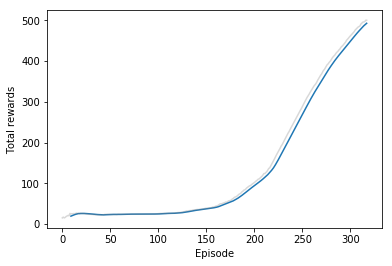

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

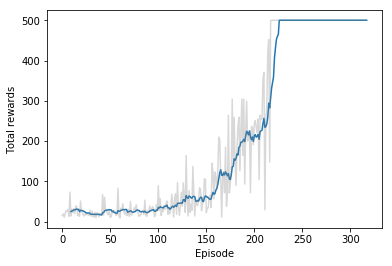

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

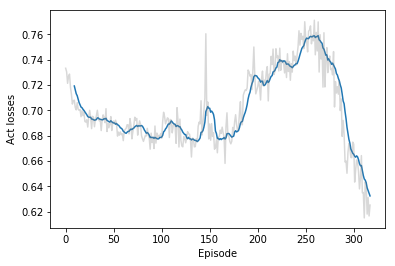

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

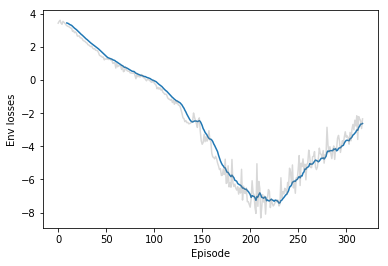

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

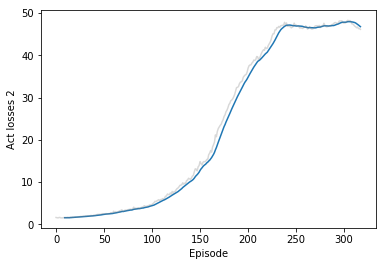

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
